**Imports**

In [1]:
import sys, os, textwrap, warnings, math, statistics, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from typing import List, Dict, Tuple
from collections import Counter

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline

warnings.filterwarnings("ignore")
np.random.seed(42)

pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 180)

**Data upload**

In [2]:
df = pd.read_csv("HW1_var_10.csv", sep=";", encoding="utf-8")

In [3]:
print(df.shape)
df.head()

(10243, 44)


,Номер варианта,ID,INCOME_BASE_TYPE,CREDIT_PURPOSE,INSURANCE_FLAG,DTI,SEX,FULL_AGE_CHILD_NUMBER,DEPENDANT_NUMBER,EDUCATION,EMPL_TYPE,EMPL_SIZE,BANKACCOUNT_FLAG,Period_at_work,age,EMPL_PROPERTY,EMPL_FORM,FAMILY_STATUS,max90days,max60days,max30days,max21days,max14days,avg_num_delay,if_zalog,num_AccountActive180,num_AccountActive90,num_AccountActive60,Active_to_All_prc,numAccountActiveAll,numAccountClosed,sum_of_paym_months,all_credits,Active_not_cc,own_closed,min_MnthAfterLoan,max_MnthAfterLoan,dlq_exist,thirty_in_a_year,sixty_in_a_year,ninety_in_a_year,thirty_vintage,sixty_vintage,ninety_vintage
0,10,1000010,2НДФЛ,Покупка автомобиля,1,0.39,мужской,0,0,среднее-специальное,рабочий,< 50,0.0,161.0,55.0,Строительство,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10,1000030,Поступление зарплаты на счет,Покупка автомобиля,1,0.39,женский,1,0,Высшее/Второе высшее/Ученая степень,специалист,>250,0.0,6.0,29.0,Другое,ООО,женат / замужем,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10,1000050,2НДФЛ,Ремонт,1,0.31,женский,0,0,незаконченное высшее,специалист,< 50,3.0,18.0,24.0,Другое,Иная форма,повторный брак,6.0,5.0,5.0,5.0,5.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,3.0,1.0,1.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,10,1000070,2НДФЛ,Покупка земли,1,NaN,женский,1,0,второе высшее,другое,NaN,1.0,74.0,39.0,Финансы,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10,1000090,2НДФЛ,Ремонт,0,0.47,женский,0,0,высшее,торговый представитель,>250,0.0,10.0,38.0,Наука,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Dataset overiew**

Dataset contains 10,243 loan applications with 44 features

**Key feature groups:**
- Demographic - age, gender, education, employment
- Financial - DTI (debt to income ratio), income type
- Credit history - num of credits, payment delays, delinquency
- Transactional - active accounts, payment months, account activity

**Initial observation**: Some records have missing values in transactional features -  they are new applicants without the banking history


In [4]:
df = df.drop(columns=['Номер варианта'])

**Initial data description**

In [5]:
def summarize_dataframe(data: pd.DataFrame) -> pd.DataFrame:
    n = len(data)
    summary_rows = []
    for col in data.columns:
        s = data[col]
        # - num of unique values in the column
        nunique = s.nunique(dropna=True)
        # - the proportion of 0 values
        n_zero = int((s == 0).sum()) if pd.api.types.is_numeric_dtype(s) else np.nan
        # - the proportion of Nans and empty values
        n_null = int(s.isna().sum())
        dtype = s.dtype

        stats = {}
        if pd.api.types.is_numeric_dtype(s):
            stats = {
                "mean": s.mean(skipna=True),
                "median": s.median(skipna=True),
                "std": s.std(skipna=True),
                "min": s.min(skipna=True),
                "max": s.max(skipna=True),
            }
        summary_rows.append({
            "column": col,
            "dtype": str(dtype),
            "nunique": nunique,
            "%_zero": (n_zero / n * 100) if not math.isnan(n_zero) else np.nan,
            "%_null": n_null / n * 100,
            **stats
        })
    out = pd.DataFrame(summary_rows).sort_values(["dtype","column"]).reset_index(drop=True)
    return out

summary = summarize_dataframe(df)
print(f"Number of lines: {len(df)}")
# - round numeric columns for better readability
summary_display = summary.copy()
numeric_cols = ['%_zero', '%_null', 'mean', 'median', 'std', 'min', 'max']
for col in numeric_cols:
    if col in summary_display.columns:
        summary_display[col] = summary_display[col].round(2)

summary_display

Number of lines: 10243


,column,dtype,nunique,%_zero,%_null,mean,median,std,min,max
0,Active_not_cc,float64,8,11.50,65.05,1.10,1.00,1.07,0.00,7.00
1,Active_to_All_prc,float64,91,4.42,65.05,0.43,0.40,0.29,0.00,1.00
2,BANKACCOUNT_FLAG,float64,5,61.08,22.49,0.38,0.00,0.86,0.00,4.00
3,DTI,float64,60,0.00,1.40,0.38,0.40,0.14,0.01,0.68
4,Period_at_work,float64,362,0.00,22.51,66.54,46.00,66.46,4.00,521.00
5,age,float64,39,0.00,22.49,36.22,34.00,8.66,23.00,61.00
6,all_credits,float64,29,0.00,65.05,5.81,5.00,4.08,1.00,34.00
7,avg_num_delay,float64,1126,14.49,65.17,0.06,0.02,0.12,0.00,1.00
8,dlq_exist,float64,2,14.61,65.05,0.58,1.00,0.49,0.00,1.00
9,if_zalog,float64,2,23.04,65.05,0.34,0.00,0.47,0.00,1.00


**Analysis of categorical features** - before filtering bank clients

In [6]:
categorical_cols = df.select_dtypes(include='object').columns.tolist()

for col in categorical_cols:
    print(f"\n {col}:")
    value_counts = df[col].value_counts(dropna=False).head(12)
    value_pct = (value_counts / len(df) * 100).round(1)

    result = pd.DataFrame({
        'Count': value_counts,
        'Percentage (%)': value_pct
    })
    print(result.to_string())


 INCOME_BASE_TYPE:
                                        Count  Percentage (%)
INCOME_BASE_TYPE                                             
2НДФЛ                                    3367            32.9
Поступление зарплаты на счет             3003            29.3
Форма банка (без печати работодателя)    2920            28.5
Свободная форма с печатью работодателя    873             8.5
NaN                                        80             0.8

 CREDIT_PURPOSE:
                                     Count  Percentage (%)
CREDIT_PURPOSE                                            
Ремонт                                5652            55.2
Покупка автомобиля                    1743            17.0
Покупка недвижимости/ строительство   1435            14.0
Отпуск                                 382             3.7
Другое                                 304             3.0
Покупка мебели                         207             2.0
Обучение                               148             1

In [7]:
print("CONCLUSIONS:")
print(f"1. Gender distribution - relatively balanced: {df['SEX'].value_counts(normalize=True).to_dict()}")
print(f"2. Most common loan purpose is: {df['CREDIT_PURPOSE'].mode()[0]}")
print(f"3. Education levels vary significantly -  it will be important for segmentation")
print(f"4. 62% missing in FAMILY_STATUS and EMPL_FORM - likely new applicants")

CONCLUSIONS:
1. Gender distribution - relatively balanced: {'мужской': 0.5534511373621009, 'женский': 0.44654886263789906}
2. Most common loan purpose is: Ремонт
3. Education levels vary significantly -  it will be important for segmentation
4. 62% missing in FAMILY_STATUS and EMPL_FORM - likely new applicants


**Identification of bank clients**

According to the task there are two types of clients -
1) existing bank clients (with history of transactions)
2) new clients (only data of the application)

Segmentation must be done on bank clients only

All recordings in the dataset: 10243
Existing bank clients: 3580 (35.0%)
New applicants (without history): 6663 (65.0%)


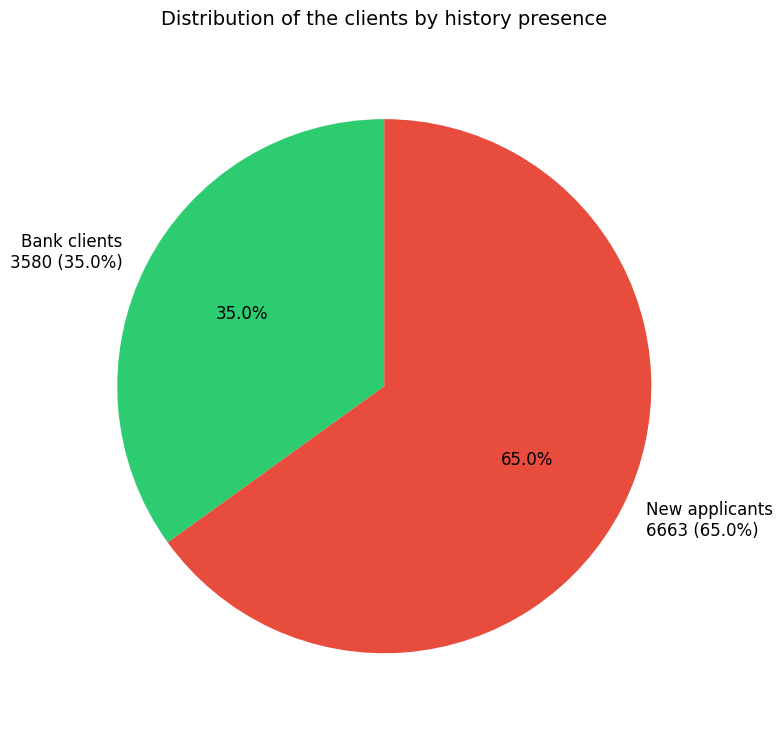


 CONCLUSION:
We will use only existing bank clients for segmentation as they have full information about transactional activity and credit history


In [8]:
# - Features which are present only for existing bank clients
bank_client_features = ['all_credits', 'numAccountActiveAll', 'sum_of_paym_months',
                        'dlq_exist', 'Active_to_All_prc']

# - Client is considered to be bank client if they have at leat one of key features
df['is_bank_client'] = df[bank_client_features].notna().any(axis=1)

print(f"All recordings in the dataset: {len(df)}")
print(f"Existing bank clients: {df['is_bank_client'].sum()} ({df['is_bank_client'].sum()/len(df)*100:.1f}%)")
print(f"New applicants (without history): {(~df['is_bank_client']).sum()} ({(~df['is_bank_client']).sum()/len(df)*100:.1f}%)")

# Visualisation
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
colors = ['#2ecc71', '#e74c3c']
labels = [f'Bank clients\n{df["is_bank_client"].sum()} ({df["is_bank_client"].sum()/len(df)*100:.1f}%)',
          f'New applicants\n{(~df["is_bank_client"]).sum()} ({(~df["is_bank_client"]).sum()/len(df)*100:.1f}%)']
sizes = [df['is_bank_client'].sum(), (~df['is_bank_client']).sum()]

ax.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90, textprops={'fontsize': 12})
ax.set_title('Distribution of the clients by history presence', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

print("\n CONCLUSION:")
print("We will use only existing bank clients for segmentation as they have full information about transactional activity and credit history")

**Missing values processing**

In [9]:
df_bank = df[df['is_bank_client'] == True]
df_clean = df_bank.copy()

# - remove technical column
if 'is_bank_client' in df_clean.columns:
    df_clean = df_clean.drop(columns=['is_bank_client'])
    print("Removed technical column: is_bank_client")

print(f"\n Initial missing values:")
print(f"   avg_num_delay: {df_clean['avg_num_delay'].isna().sum()} ({df_clean['avg_num_delay'].isna().sum()/len(df_clean)*100:.2f}%)")
print(f"   max14days: {df_clean['max14days'].isna().sum()} ({df_clean['max14days'].isna().sum()/len(df_clean)*100:.2f}%)")
print(f"   max21days: {df_clean['max21days'].isna().sum()} ({df_clean['max21days'].isna().sum()/len(df_clean)*100:.2f}%)")
print(f"   max30days: {df_clean['max30days'].isna().sum()} ({df_clean['max30days'].isna().sum()/len(df_clean)*100:.2f}%)")
print(f"   max60days: {df_clean['max60days'].isna().sum()} ({df_clean['max60days'].isna().sum()/len(df_clean)*100:.2f}%)")
print(f"   max90days: {df_clean['max90days'].isna().sum()} ({df_clean['max90days'].isna().sum()/len(df_clean)*100:.2f}%)")


Removed technical column: is_bank_client

 Initial missing values:
   avg_num_delay: 12 (0.34%)
   max14days: 4 (0.11%)
   max21days: 4 (0.11%)
   max30days: 4 (0.11%)
   max60days: 4 (0.11%)
   max90days: 4 (0.11%)


In [10]:
# - fill features related to delays with 0 (no delay = 0)
print(f"\n Filling delay-related features with 0:")
delay_features = ['avg_num_delay', 'max14days', 'max21days', 'max30days', 'max60days', 'max90days']

for col in delay_features:
    if col in df_clean.columns:
        missing_before = df_clean[col].isna().sum()
        df_clean[col].fillna(0, inplace=True)
        print(f"{col}: filled {missing_before} missing values with 0")

# - check the final result
print(f"\n Final check:")
remaining_missing = df_clean.isnull().sum().sum()
print(f"Total missing values: {remaining_missing}")

if remaining_missing > 0:
    print(f"\n Remaining missing values by feature:")
    missing_features = df_clean.isnull().sum()
    missing_features = missing_features[missing_features > 0].sort_values(ascending=False)
    for feat, count in missing_features.items():
        print(f"{feat}: {count} ({count/len(df_clean)*100:.2f}%)")
else:
    print("No missing values - dataset is clean")


 Filling delay-related features with 0:
avg_num_delay: filled 12 missing values with 0
max14days: filled 4 missing values with 0
max21days: filled 4 missing values with 0
max30days: filled 4 missing values with 0
max60days: filled 4 missing values with 0
max90days: filled 4 missing values with 0

 Final check:
Total missing values: 0
No missing values - dataset is clean


**Stats and visualisation**

In [11]:
print(f"\n Dataset dimensions: {df_clean.shape}")
print(f" Features: {len(df_clean.columns)}")
print(f" Records: {len(df_clean)}")
print(f" Missing values: {df_clean.isnull().sum().sum()}")


 Dataset dimensions: (3580, 43)
 Features: 43
 Records: 3580
 Missing values: 0


In [12]:
# - key stats for segmentation features
print("\n Key features statistics:")
key_features = ['age', 'DTI', 'all_credits', 'dlq_exist', 'Active_to_All_prc',
                'sum_of_paym_months', 'numAccountActiveAll', 'avg_num_delay',
                'max90days', 'Active_not_cc']
key_features = [f for f in key_features if f in df_clean.columns]

stats_data = []
for col in key_features:
    stats_data.append({
        'Feature': col,
        'Mean': df_clean[col].mean(),
        'Median': df_clean[col].median(),
        'Std': df_clean[col].std(),
        'Min': df_clean[col].min(),
        'Max': df_clean[col].max()
    })

stats_df = pd.DataFrame(stats_data)
for col in ['Mean', 'Median', 'Std', 'Min', 'Max']:
    stats_df[col] = stats_df[col].round(2)

print(stats_df.to_string(index=False))


 Key features statistics:
            Feature  Mean  Median   Std   Min    Max
                age 35.81   34.00  8.42 23.00  61.00
                DTI  0.39    0.40  0.14  0.01   0.59
        all_credits  5.81    5.00  4.08  1.00  34.00
          dlq_exist  0.58    1.00  0.49  0.00   1.00
  Active_to_All_prc  0.43    0.40  0.29  0.00   1.00
 sum_of_paym_months 82.71   65.00 71.16  0.00 584.00
numAccountActiveAll  2.23    2.00  1.66  0.00  13.00
      avg_num_delay  0.06    0.01  0.12  0.00   1.00
          max90days  1.63    1.00  1.98  0.00  29.00
      Active_not_cc  1.10    1.00  1.07  0.00   7.00


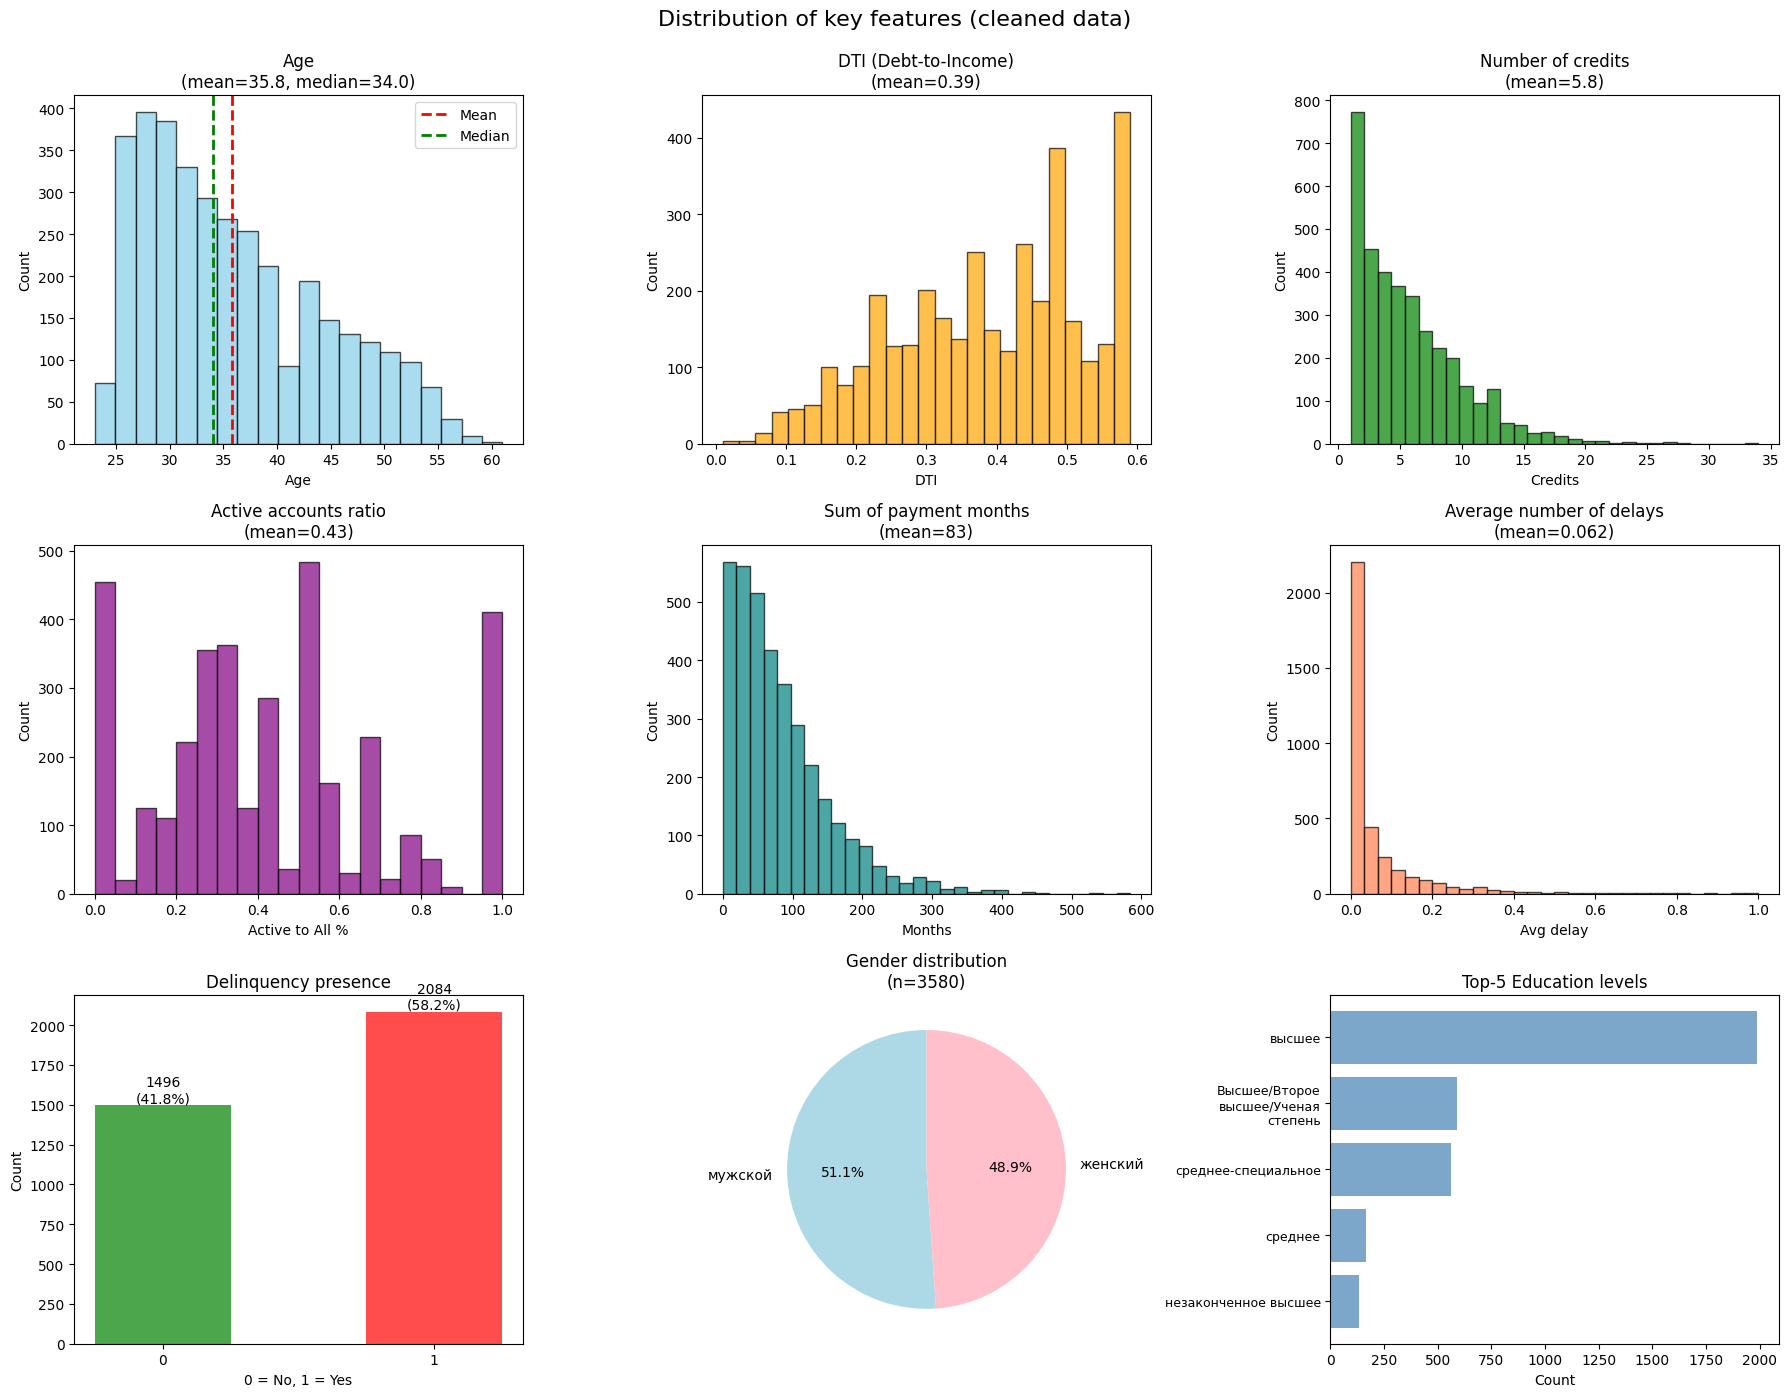

In [13]:
# visualisation
fig, axes = plt.subplots(3, 3, figsize=(18, 14))
fig.suptitle('Distribution of key features (cleaned data)', fontsize=16, y=0.995)

# 1. Age
if 'age' in df_clean.columns:
    axes[0, 0].hist(df_clean['age'], bins=20, edgecolor='black', alpha=0.7, color='skyblue')
    axes[0, 0].set_title(f'Age\n(mean={df_clean["age"].mean():.1f}, median={df_clean["age"].median():.1f})')
    axes[0, 0].set_xlabel('Age')
    axes[0, 0].set_ylabel('Count')
    axes[0, 0].axvline(df_clean['age'].mean(), color='red', linestyle='--', linewidth=2, label='Mean')
    axes[0, 0].axvline(df_clean['age'].median(), color='green', linestyle='--', linewidth=2, label='Median')
    axes[0, 0].legend()

# 2. DTI
if 'DTI' in df_clean.columns:
    axes[0, 1].hist(df_clean['DTI'], bins=25, edgecolor='black', alpha=0.7, color='orange')
    axes[0, 1].set_title(f'DTI (Debt-to-Income)\n(mean={df_clean["DTI"].mean():.2f})')
    axes[0, 1].set_xlabel('DTI')
    axes[0, 1].set_ylabel('Count')

# 3. Num of credits
if 'all_credits' in df_clean.columns:
    axes[0, 2].hist(df_clean['all_credits'], bins=min(30, int(df_clean['all_credits'].max())),
                    edgecolor='black', alpha=0.7, color='green')
    axes[0, 2].set_title(f'Number of credits\n(mean={df_clean["all_credits"].mean():.1f})')
    axes[0, 2].set_xlabel('Credits')
    axes[0, 2].set_ylabel('Count')

# 4. Ratio of active accounts
if 'Active_to_All_prc' in df_clean.columns:
    axes[1, 0].hist(df_clean['Active_to_All_prc'], bins=20, edgecolor='black', alpha=0.7, color='purple')
    axes[1, 0].set_title(f'Active accounts ratio\n(mean={df_clean["Active_to_All_prc"].mean():.2f})')
    axes[1, 0].set_xlabel('Active to All %')
    axes[1, 0].set_ylabel('Count')

# 5. Payment months
if 'sum_of_paym_months' in df_clean.columns:
    axes[1, 1].hist(df_clean['sum_of_paym_months'], bins=30, edgecolor='black', alpha=0.7, color='teal')
    axes[1, 1].set_title(f'Sum of payment months\n(mean={df_clean["sum_of_paym_months"].mean():.0f})')
    axes[1, 1].set_xlabel('Months')
    axes[1, 1].set_ylabel('Count')

# 6. Average delay
if 'avg_num_delay' in df_clean.columns:
    axes[1, 2].hist(df_clean['avg_num_delay'], bins=30, edgecolor='black', alpha=0.7, color='coral')
    axes[1, 2].set_title(f'Average number of delays\n(mean={df_clean["avg_num_delay"].mean():.3f})')
    axes[1, 2].set_xlabel('Avg delay')
    axes[1, 2].set_ylabel('Count')

# 7. Delinquency
if 'dlq_exist' in df_clean.columns:
    dlq_counts = df_clean['dlq_exist'].value_counts().sort_index()
    axes[2, 0].bar(dlq_counts.index, dlq_counts.values, color=['green', 'red'], alpha=0.7, width=0.5)
    axes[2, 0].set_title('Delinquency presence')
    axes[2, 0].set_xlabel('0 = No, 1 = Yes')
    axes[2, 0].set_ylabel('Count')
    axes[2, 0].set_xticks([0, 1])
    for i, v in enumerate(dlq_counts.values):
        axes[2, 0].text(dlq_counts.index[i], v, f'{v}\n({v/len(df_clean)*100:.1f}%)',
                       ha='center', va='bottom', fontsize=10)

# 8. Gender
if 'SEX' in df_clean.columns:
    sex_counts = df_clean['SEX'].value_counts()
    colors_sex = ['lightblue' if 'мужской' in idx else 'pink' for idx in sex_counts.index]
    axes[2, 1].pie(sex_counts.values, labels=sex_counts.index, autopct='%1.1f%%',
                   colors=colors_sex, startangle=90)
    axes[2, 1].set_title(f'Gender distribution\n(n={len(df_clean)})')

# 9. Education (top 5)
if 'EDUCATION' in df_clean.columns:
    edu_counts = df_clean['EDUCATION'].value_counts().head(5)
    axes[2, 2].barh(range(len(edu_counts)), edu_counts.values, color='steelblue', alpha=0.7)
    axes[2, 2].set_yticks(range(len(edu_counts)))
    axes[2, 2].set_yticklabels([textwrap.fill(text, 20) for text in edu_counts.index], fontsize=9)
    axes[2, 2].set_title('Top-5 Education levels')
    axes[2, 2].set_xlabel('Count')
    axes[2, 2].invert_yaxis()

plt.tight_layout()
plt.show()

In [14]:
print(" CONCLUSIONS:")
print(f"1. Dataset successfully cleaned, contains {len(df_clean)} bank clients")
print(f"2. Avg client age: {df_clean['age'].mean():.1f} years (range: {df_clean['age'].min():.0f}-{df_clean['age'].max():.0f})")
print(f"3. Avg DTI (debt-to-income): {df_clean['DTI'].mean():.2f}")

if 'dlq_exist' in df_clean.columns:
    dlq_yes = (df_clean['dlq_exist']==1).sum()
    dlq_pct = dlq_yes/len(df_clean)*100
    print(f"4. Clients with delinquency history: {dlq_yes} ({dlq_pct:.1f}%)")

if 'all_credits' in df_clean.columns:
    print(f"5. Avg number of credits per client: {df_clean['all_credits'].mean():.1f}")

if 'Active_to_All_prc' in df_clean.columns:
    print(f"6. Avg active accounts ratio: {df_clean['Active_to_All_prc'].mean():.2f}")

if 'sum_of_paym_months' in df_clean.columns:
    print(f"7. Avg payment history: {df_clean['sum_of_paym_months'].mean():.0f} months")

 CONCLUSIONS:
1. Dataset successfully cleaned, contains 3580 bank clients
2. Avg client age: 35.8 years (range: 23-61)
3. Avg DTI (debt-to-income): 0.39
4. Clients with delinquency history: 2084 (58.2%)
5. Avg number of credits per client: 5.8
6. Avg active accounts ratio: 0.43
7. Avg payment history: 83 months


**Outliners detection - Box Plots**

box Plots help us to identify the otlining data in numerical features - they can be either errors or extreme values which represent important segments of customers

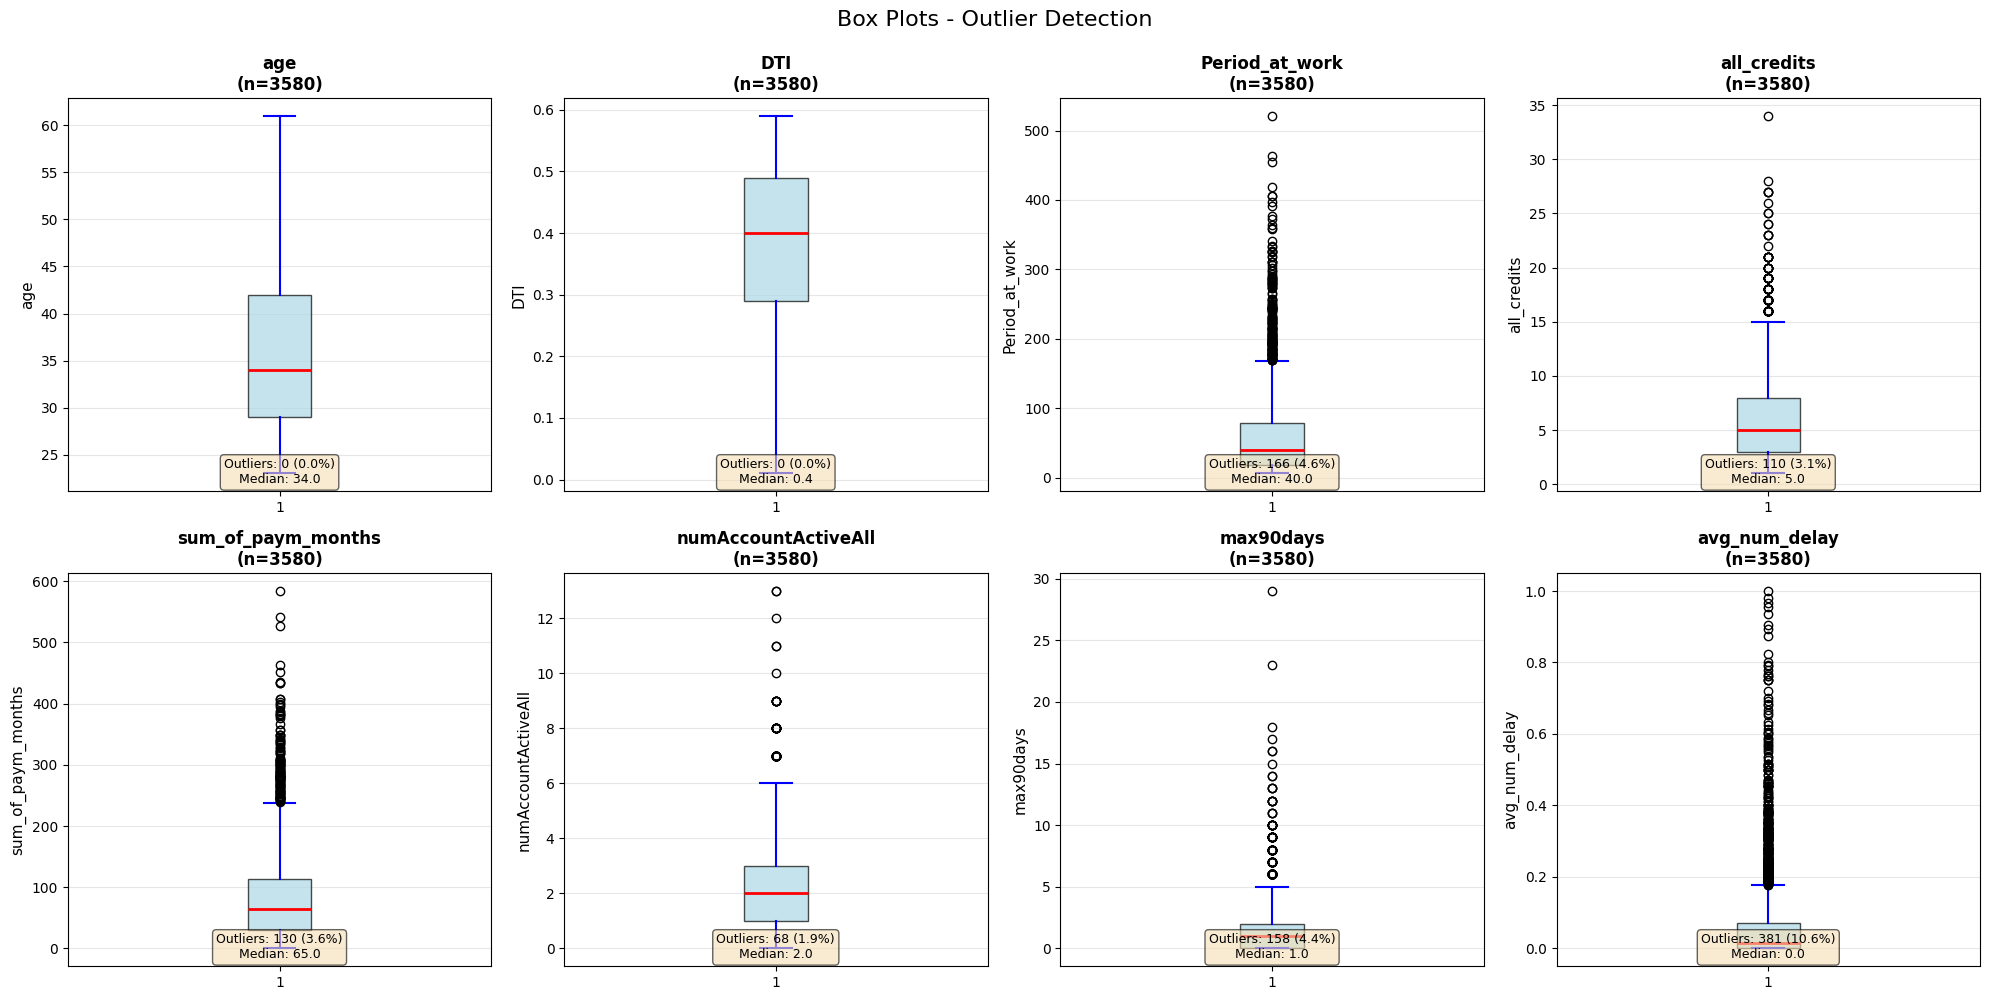

In [15]:
key_numeric_outliers = ['age', 'DTI', 'Period_at_work', 'all_credits',
                        'sum_of_paym_months', 'numAccountActiveAll',
                        'max90days', 'avg_num_delay']

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle('Box Plots - Outlier Detection', fontsize=16, y=0.995)
axes = axes.flatten()

for idx, col in enumerate(key_numeric_outliers):
    ax = axes[idx]
    data_clean_box = df_clean[col].dropna()

    bp = ax.boxplot(data_clean_box, vert=True, patch_artist=True,
                    boxprops=dict(facecolor='lightblue', alpha=0.7),
                    medianprops=dict(color='red', linewidth=2),
                    whiskerprops=dict(color='blue', linewidth=1.5),
                    capprops=dict(color='blue', linewidth=1.5))

    ax.set_ylabel(f'{col}', fontsize=11)
    ax.set_title(f'{col}\n(n={len(data_clean_box)})', fontsize=12, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)

    # - calculating outlier stats
    q1, q3 = data_clean_box.quantile([0.25, 0.75])
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = ((data_clean_box < lower_bound) | (data_clean_box > upper_bound)).sum()
    outlier_pct = outliers / len(data_clean_box) * 100

    # -adding stats text
    ax.text(0.5, 0.02, f'Outliers: {outliers} ({outlier_pct:.1f}%)\nMedian: {data_clean_box.median():.1f}',
            transform=ax.transAxes, ha='center', fontsize=9,
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.6))

plt.tight_layout()
plt.show()

In [16]:

print("\n CONCLUSIONS:")
print("1. DTI: Most values between 0.3-0.5 - some outliers at extremes")
print("2. all_credits: right skewed distribution - some clients with 20 and more credits")
print("3. sum_of_paym_months: high variability - reflects different credit histories")
print("4. outliers are preserved as they represent legitimate customer segments")


 CONCLUSIONS:
1. DTI: Most values between 0.3-0.5 - some outliers at extremes
2. all_credits: right skewed distribution - some clients with 20 and more credits
3. sum_of_paym_months: high variability - reflects different credit histories
4. outliers are preserved as they represent legitimate customer segments


**Final datamart for segmentation**

In [17]:
df_final = df_clean.copy()

# - separate features (by type)
num_features = df_final.select_dtypes(include=[np.number]).columns.tolist()
cat_features = df_final.select_dtypes(include='object').columns.tolist()

print(f"\n Numerical features ({len(num_features)}):")
for i, col in enumerate(num_features, 1):
    print(f"   {i:2d}. {col}")

print(f"\n Categorical features ({len(cat_features)}):")
for i, col in enumerate(cat_features, 1):
    print(f"   {i:2d}. {col}")


 Numerical features (34):
    1. ID
    2. INSURANCE_FLAG
    3. DTI
    4. FULL_AGE_CHILD_NUMBER
    5. DEPENDANT_NUMBER
    6. BANKACCOUNT_FLAG
    7. Period_at_work
    8. age
    9. max90days
   10. max60days
   11. max30days
   12. max21days
   13. max14days
   14. avg_num_delay
   15. if_zalog
   16. num_AccountActive180
   17. num_AccountActive90
   18. num_AccountActive60
   19. Active_to_All_prc
   20. numAccountActiveAll
   21. numAccountClosed
   22. sum_of_paym_months
   23. all_credits
   24. Active_not_cc
   25. own_closed
   26. min_MnthAfterLoan
   27. max_MnthAfterLoan
   28. dlq_exist
   29. thirty_in_a_year
   30. sixty_in_a_year
   31. ninety_in_a_year
   32. thirty_vintage
   33. sixty_vintage
   34. ninety_vintage

 Categorical features (9):
    1. INCOME_BASE_TYPE
    2. CREDIT_PURPOSE
    3. SEX
    4. EDUCATION
    5. EMPL_TYPE
    6. EMPL_SIZE
    7. EMPL_PROPERTY
    8. EMPL_FORM
    9. FAMILY_STATUS


In [18]:
print("Preview of final datamart - first 5 rows:")

display_cols = ['ID', 'age', 'SEX', 'EDUCATION', 'DTI', 'all_credits',
                'dlq_exist', 'sum_of_paym_months', 'Active_to_All_prc']
display_cols = [col for col in display_cols if col in df_final.columns]

df_final[display_cols].head()

Preview of final datamart - first 5 rows:


,ID,age,SEX,EDUCATION,DTI,all_credits,dlq_exist,sum_of_paym_months,Active_to_All_prc
2,1000050,24.0,женский,незаконченное высшее,0.31,1.0,0.0,3.0,1.000000
7,1000150,32.0,мужской,Высшее/Второе высшее/Ученая степень,0.47,10.0,1.0,130.0,0.300000
11,1000230,25.0,женский,высшее,0.49,7.0,1.0,44.0,0.428571
13,1000270,34.0,мужской,незаконченное высшее,0.45,2.0,1.0,20.0,0.000000
14,1000290,31.0,мужской,высшее,0.25,6.0,1.0,48.0,0.666667


**SEGMENTATION - TWO METHODS**


**1. KMeans (unsupervised)**

**2. RFM segmentation (Recency, Frequency, Monetary-like)**

**Feature preparation for segmnetation**

In [19]:
# - create copy for segmentation
df_segment = df_final.copy()

# - select key features for segmentation
behavioral_features = [
    'all_credits',              # total num of credits
    'numAccountActiveAll',      # num of active accounts
    'numAccountClosed',         # num of closed accounts
    'Active_to_All_prc',        # ratio of active accounts
    'sum_of_paym_months',       # total payment months
    'avg_num_delay',            # avg delays
    'dlq_exist',                # delinquency flag
    'max90days',                # max 90-day delays
    'Active_not_cc',            # active non-credit-card accounts
]

demographic_features = [
    'age',                      # age
    'DTI',                      # dti ratio
    'FULL_AGE_CHILD_NUMBER',    # num of children
    'Period_at_work',           # work period
]

categorical_features = [
    'SEX',                      # gender
    'EDUCATION',                # rducation level
    'INCOME_BASE_TYPE',         # income type
]

# - combining all features
features_for_clustering = behavioral_features + demographic_features + categorical_features

In [20]:
# - verifying that all features exist
features_for_clustering = [f for f in features_for_clustering if f in df_segment.columns]

print(f"\n Total features selected for clustering: {len(features_for_clustering)}")
for i, feat in enumerate(features_for_clustering, 1):
    print(f"   {i:2d}. {feat}")

# - creating feature matrix
df_features = df_segment[features_for_clustering].copy()

print(f"\n Feature matrix shape: {df_features.shape}")
print(f"Records: {df_features.shape[0]}")
print(f"Features: {df_features.shape[1]}")


 Total features selected for clustering: 16
    1. all_credits
    2. numAccountActiveAll
    3. numAccountClosed
    4. Active_to_All_prc
    5. sum_of_paym_months
    6. avg_num_delay
    7. dlq_exist
    8. max90days
    9. Active_not_cc
   10. age
   11. DTI
   12. FULL_AGE_CHILD_NUMBER
   13. Period_at_work
   14. SEX
   15. EDUCATION
   16. INCOME_BASE_TYPE

 Feature matrix shape: (3580, 16)
Records: 3580
Features: 16


**Encoding and scaling**

In [21]:
# - separate numerical and categorical
numerical_features = [f for f in features_for_clustering if f not in categorical_features]

print(f"\n Numerical features ({len(numerical_features)}):")
for feat in numerical_features:
    print(f"   • {feat}")

print(f"\n Categorical features ({len(categorical_features)}):")
for feat in categorical_features:
    unique_vals = df_features[feat].nunique()
    print(f"   • {feat} ({unique_vals} unique values)")


 Numerical features (13):
   • all_credits
   • numAccountActiveAll
   • numAccountClosed
   • Active_to_All_prc
   • sum_of_paym_months
   • avg_num_delay
   • dlq_exist
   • max90days
   • Active_not_cc
   • age
   • DTI
   • FULL_AGE_CHILD_NUMBER
   • Period_at_work

 Categorical features (3):
   • SEX (2 unique values)
   • EDUCATION (9 unique values)
   • INCOME_BASE_TYPE (4 unique values)


one-hot encoding

In [22]:
# one-hot encoding for categorical features
df_encoded = pd.get_dummies(df_features, columns=categorical_features, drop_first=True)

print(f"Shape after encoding: {df_encoded.shape}")
print(f"Features increased from {df_features.shape[1]} to {df_encoded.shape[1]}")

Shape after encoding: (3580, 25)
Features increased from 16 to 25


standardization

In [23]:
# - standardization (scaling)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_encoded)

print(f"Scaled feature matrix shape: {X_scaled.shape}")
print(f"Mean (should be ~0): {X_scaled.mean():.6f}")
print(f"Std (should be ~1): {X_scaled.std():.6f}")

Scaled feature matrix shape: (3580, 25)
Mean (should be ~0): 0.000000
Std (should be ~1): 1.000000


In [24]:
# - convert back to df for convenience
X_scaled_df = pd.DataFrame(X_scaled, columns=df_encoded.columns, index=df_encoded.index)

print("\n Data is ready for clustering!")
print(f"Final shape: {X_scaled_df.shape}")


 Data is ready for clustering!
Final shape: (3580, 25)


**Determination of the optimal number of clusters**

We test different number (k) of clusters (from 3 to 10)

Every time KMeans is trained on k kluster, than we calculate 4 different metrics of clusterisation quality

1) inertia — inner sum of distances in the cluster (smaller - better)
2) silhouette — how clusters are separated (closer to 1 — better)
3) calinski_harabasz — relation of between-cluster dispersion to inner-cluster (bigger — better)
4) davies-bouldin - average similarity of clusters (lower - better)

In [25]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# - testinf different num of clusters
k_range = range(3, 11)
results = []

for k in k_range:
    # - fit kmeans
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10, max_iter=300)
    labels = kmeans.fit_predict(X_scaled)

    # - calculating metrics
    inertia = kmeans.inertia_
    silhouette = silhouette_score(X_scaled, labels)
    calinski = calinski_harabasz_score(X_scaled, labels)
    davies = davies_bouldin_score(X_scaled, labels)

    results.append({
        'n_clusters': k,
        'inertia': inertia,
        'silhouette': silhouette,
        'calinski_harabasz': calinski,
        'davies_bouldin': davies
    })

    print(f"   K={k:2d} | Inertia: {inertia:10.2f} | Silhouette: {silhouette:.4f} | "
          f"Calinski-Harabasz: {calinski:10.2f} | Davies-Bouldin: {davies:.4f}")

# Convert to DataFrame
results_df = pd.DataFrame(results)

   K= 3 | Inertia:   75954.34 | Silhouette: 0.0982 | Calinski-Harabasz:     318.96 | Davies-Bouldin: 3.0088
   K= 4 | Inertia:   72531.47 | Silhouette: 0.1146 | Calinski-Harabasz:     278.87 | Davies-Bouldin: 2.7095
   K= 5 | Inertia:   69007.93 | Silhouette: 0.1306 | Calinski-Harabasz:     265.40 | Davies-Bouldin: 2.2980
   K= 6 | Inertia:   65406.75 | Silhouette: 0.1364 | Calinski-Harabasz:     263.30 | Davies-Bouldin: 2.0203
   K= 7 | Inertia:   64226.34 | Silhouette: 0.1365 | Calinski-Harabasz:     234.33 | Davies-Bouldin: 2.0134
   K= 8 | Inertia:   59309.69 | Silhouette: 0.1142 | Calinski-Harabasz:     259.75 | Davies-Bouldin: 1.8998
   K= 9 | Inertia:   57641.69 | Silhouette: 0.1073 | Calinski-Harabasz:     246.71 | Davies-Bouldin: 1.9423
   K=10 | Inertia:   54051.12 | Silhouette: 0.1105 | Calinski-Harabasz:     260.15 | Davies-Bouldin: 1.7579


In [26]:
results_df

,n_clusters,inertia,silhouette,calinski_harabasz,davies_bouldin
0,3,75954.340387,0.098160,318.960208,3.008808
1,4,72531.469067,0.114648,278.865647,2.709515
2,5,69007.927726,0.130588,265.401240,2.297959
3,6,65406.754897,0.136424,263.303869,2.020302
4,7,64226.343179,0.136505,234.334728,2.013427
5,8,59309.686380,0.114173,259.749911,1.899820
6,9,57641.693346,0.107305,246.710185,1.942263
7,10,54051.124480,0.110473,260.149764,1.757872


Visualisation of metrics for cluster num choosing

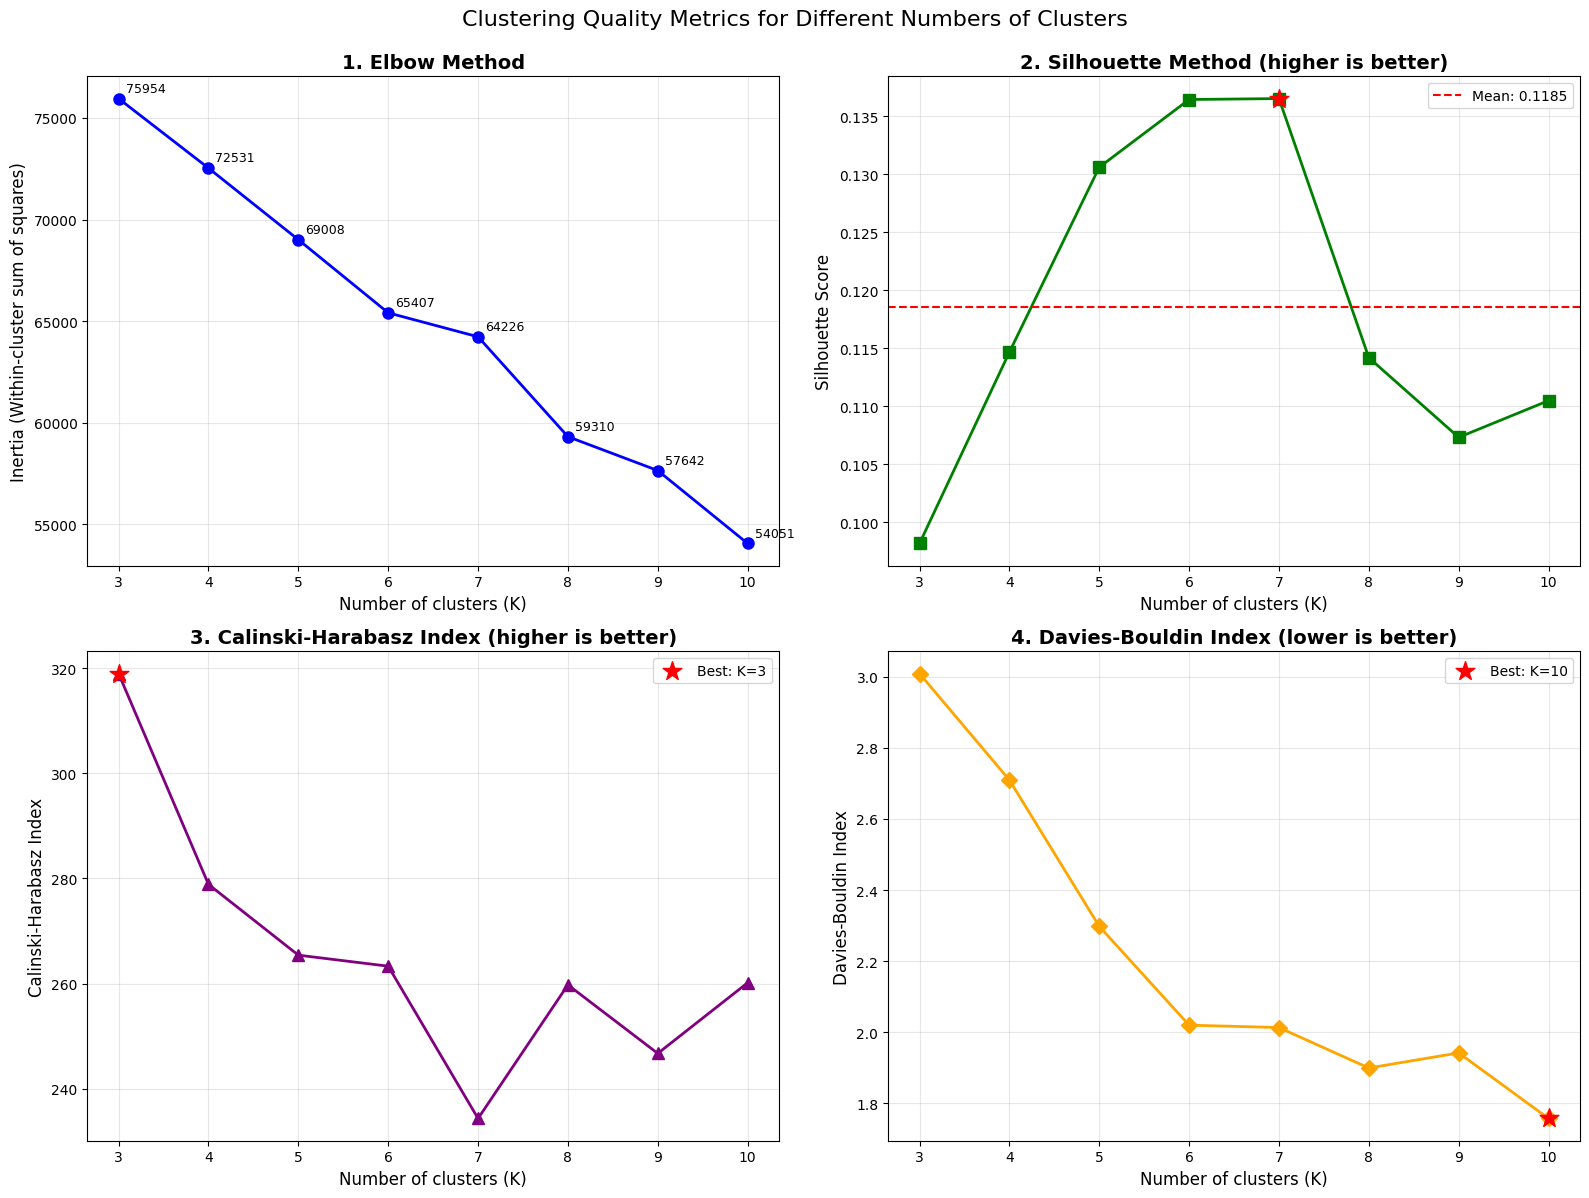

In [27]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Clustering Quality Metrics for Different Numbers of Clusters', fontsize=16, y=0.995)

# 1. Elbow Method (Inertia)
axes[0, 0].plot(results_df['n_clusters'], results_df['inertia'],
                marker='o', linewidth=2, markersize=8, color='blue')
axes[0, 0].set_xlabel('Number of clusters (K)', fontsize=12)
axes[0, 0].set_ylabel('Inertia (Within-cluster sum of squares)', fontsize=12)
axes[0, 0].set_title('1. Elbow Method', fontsize=14, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_xticks(results_df['n_clusters'])

# - annotation for elbow
for i, row in results_df.iterrows():
    axes[0, 0].annotate(f'{row["inertia"]:.0f}',
                       xy=(row['n_clusters'], row['inertia']),
                       xytext=(5, 5), textcoords='offset points', fontsize=9)

# 2. Silhouette Score (bigger - better)
axes[0, 1].plot(results_df['n_clusters'], results_df['silhouette'],
                marker='s', linewidth=2, markersize=8, color='green')
axes[0, 1].set_xlabel('Number of clusters (K)', fontsize=12)
axes[0, 1].set_ylabel('Silhouette Score', fontsize=12)
axes[0, 1].set_title('2. Silhouette Method (higher is better)', fontsize=14, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_xticks(results_df['n_clusters'])
axes[0, 1].axhline(y=results_df['silhouette'].mean(), color='red',
                   linestyle='--', label=f'Mean: {results_df["silhouette"].mean():.4f}')
axes[0, 1].legend()

# - highlight best
best_silhouette_k = results_df.loc[results_df['silhouette'].idxmax(), 'n_clusters']
best_silhouette_val = results_df['silhouette'].max()
axes[0, 1].scatter([best_silhouette_k], [best_silhouette_val],
                   s=200, c='red', marker='*', zorder=5,
                   label=f'Best: K={best_silhouette_k}')

# 3. Calinski-Harabasz Index (bigger - better)
axes[1, 0].plot(results_df['n_clusters'], results_df['calinski_harabasz'],
                marker='^', linewidth=2, markersize=8, color='purple')
axes[1, 0].set_xlabel('Number of clusters (K)', fontsize=12)
axes[1, 0].set_ylabel('Calinski-Harabasz Index', fontsize=12)
axes[1, 0].set_title('3. Calinski-Harabasz Index (higher is better)', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_xticks(results_df['n_clusters'])

# - highlight best
best_calinski_k = results_df.loc[results_df['calinski_harabasz'].idxmax(), 'n_clusters']
best_calinski_val = results_df['calinski_harabasz'].max()
axes[1, 0].scatter([best_calinski_k], [best_calinski_val],
                   s=200, c='red', marker='*', zorder=5,
                   label=f'Best: K={best_calinski_k}')
axes[1, 0].legend()

# 4. Davies-Bouldin Index (lower - better)
axes[1, 1].plot(results_df['n_clusters'], results_df['davies_bouldin'],
                marker='D', linewidth=2, markersize=8, color='orange')
axes[1, 1].set_xlabel('Number of clusters (K)', fontsize=12)
axes[1, 1].set_ylabel('Davies-Bouldin Index', fontsize=12)
axes[1, 1].set_title('4. Davies-Bouldin Index (lower is better)', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_xticks(results_df['n_clusters'])

# - highlight best
best_davies_k = results_df.loc[results_df['davies_bouldin'].idxmin(), 'n_clusters']
best_davies_val = results_df['davies_bouldin'].min()
axes[1, 1].scatter([best_davies_k], [best_davies_val],
                   s=200, c='red', marker='*', zorder=5,
                   label=f'Best: K={best_davies_k}')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

In [28]:
# - summary
print(f"\n Best K according to different methods:")
print(f"   • Silhouette Score:      K = {best_silhouette_k} (score: {best_silhouette_val:.4f})")
print(f"   • Calinski-Harabasz:     K = {best_calinski_k} (score: {best_calinski_val:.2f})")
print(f"   • Davies-Bouldin:        K = {best_davies_k} (score: {best_davies_val:.4f})")


 Best K according to different methods:
   • Silhouette Score:      K = 7 (score: 0.1365)
   • Calinski-Harabasz:     K = 3 (score: 318.96)
   • Davies-Bouldin:        K = 10 (score: 1.7579)


Metrics analysis:

- silhouette: max with k = 7 and almost the same with k = 6
- davies-bouldin best with k = 10 but after 7 silhouette drops
- inertia always drops — but the descrease slows after k = 6-7
- alinski-Harabasz still relatively high with k = 6

We choose **k = 6** for segmentation - balance of metrics and good business interpretation

**K Means segmentation for k = 6**

In [29]:
optimal_k = 6

# - fit final Kmeans model
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=20, max_iter=500)
kmeans_labels = kmeans_final.fit_predict(X_scaled)

# - add cluster labels to df
df_segment['cluster_kmeans'] = kmeans_labels

In [30]:
print(f"\n Cluster distribution:")

cluster_counts = df_segment['cluster_kmeans'].value_counts().sort_index()
print("\nCluster | Count | Percentage")
print("-" * 40)
for cluster_id, count in cluster_counts.items():
    percentage = (count / len(df_segment)) * 100
    print(f"   {cluster_id}    | {count:5d} | {percentage:6.2f}%")


 Cluster distribution:

Cluster | Count | Percentage
----------------------------------------
   0    |   474 |  13.24%
   1    |   637 |  17.79%
   2    |   618 |  17.26%
   3    |   115 |   3.21%
   4    |   131 |   3.66%
   5    |  1605 |  44.83%


In [31]:
# - final metrics
final_silhouette = silhouette_score(X_scaled, kmeans_labels)
final_calinski = calinski_harabasz_score(X_scaled, kmeans_labels)
final_davies = davies_bouldin_score(X_scaled, kmeans_labels)

print(f"\n Final clustering quality metrics:")
print(f"   • Silhouette Score:      {final_silhouette:.4f}")
print(f"   • Calinski-Harabasz:     {final_calinski:.2f}")
print(f"   • Davies-Bouldin:        {final_davies:.4f}")
print(f"   • Inertia:               {kmeans_final.inertia_:.2f}")


 Final clustering quality metrics:
   • Silhouette Score:      0.1364
   • Calinski-Harabasz:     263.30
   • Davies-Bouldin:        2.0203
   • Inertia:               65406.75


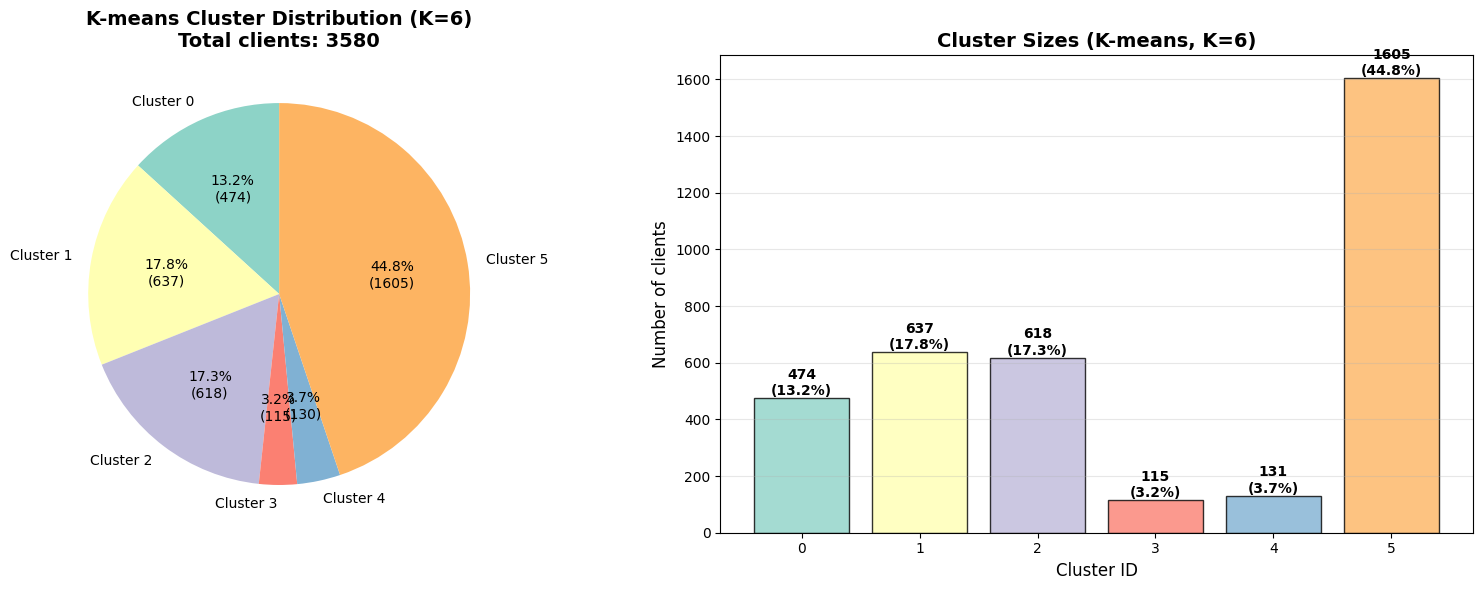

In [32]:
# - visualization of cluster sizes
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# pie chart
colors_pie = plt.cm.Set3(range(optimal_k))
axes[0].pie(cluster_counts.values, labels=[f'Cluster {i}' for i in cluster_counts.index],
            autopct=lambda pct: f'{pct:.1f}%\n({int(pct/100*len(df_segment))})',
            colors=colors_pie, startangle=90)
axes[0].set_title(f'K-means Cluster Distribution (K={optimal_k})\nTotal clients: {len(df_segment)}',
                  fontsize=14, fontweight='bold')

# bar chart
axes[1].bar(cluster_counts.index, cluster_counts.values, color=colors_pie, alpha=0.8, edgecolor='black')
axes[1].set_xlabel('Cluster ID', fontsize=12)
axes[1].set_ylabel('Number of clients', fontsize=12)
axes[1].set_title(f'Cluster Sizes (K-means, K={optimal_k})', fontsize=14, fontweight='bold')
axes[1].set_xticks(cluster_counts.index)
axes[1].grid(axis='y', alpha=0.3)

# adding value labels on bars
for i, (cluster_id, count) in enumerate(cluster_counts.items()):
    percentage = (count / len(df_segment)) * 100
    axes[1].text(cluster_id, count, f'{count}\n({percentage:.1f}%)',
                ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

**Cluster profiling**

In [33]:
# - selecting key features for profiling
profiling_features = [
    'age', 'DTI', 'all_credits', 'numAccountActiveAll', 'numAccountClosed',
    'Active_to_All_prc', 'sum_of_paym_months', 'avg_num_delay', 'dlq_exist',
    'max90days', 'Active_not_cc', 'Period_at_work', 'FULL_AGE_CHILD_NUMBER'
]

# - calculate mean values for each cluster
cluster_profiles = df_segment.groupby('cluster_kmeans')[profiling_features].mean()

# - rounding for readability
cluster_profiles_display = cluster_profiles.round(2)

print("\n Cluster Profiles (Mean values):\n")
print(cluster_profiles_display.to_string())


 Cluster Profiles (Mean values):

                  age   DTI  all_credits  numAccountActiveAll  numAccountClosed  Active_to_All_prc  sum_of_paym_months  avg_num_delay  dlq_exist  max90days  Active_not_cc  Period_at_work  FULL_AGE_CHILD_NUMBER
cluster_kmeans                                                                                                                                                                                                   
0               35.17  0.38         5.19                 2.05              3.15               0.43               78.66           0.06       0.58       1.49           0.96           56.64                   0.44
1               38.65  0.40         4.42                 1.62              2.80               0.41               59.06           0.08       0.52       1.22           0.80           65.60                   0.62
2               38.35  0.45        12.10                 4.38              7.72               0.38              183.69       

In [34]:
# - adding categorical feature distributions
print("Categorical Features by Cluster")

# - gender distribution
print("\n Gender distribution by cluster:")
gender_dist = pd.crosstab(df_segment['cluster_kmeans'], df_segment['SEX'], normalize='index') * 100
print(gender_dist.round(1).to_string())

# - education distribution
print("\n Top-3 Education levels by cluster:")
for cluster_id in sorted(df_segment['cluster_kmeans'].unique()):
    cluster_data = df_segment[df_segment['cluster_kmeans'] == cluster_id]
    top_education = cluster_data['EDUCATION'].value_counts().head(3)
    print(f"\n   Cluster {cluster_id}:")
    for edu, count in top_education.items():
        pct = (count / len(cluster_data)) * 100
        print(f"      • {edu}: {count} ({pct:.1f}%)")

# - income type distribution
print("\n Income type distribution by cluster:")
income_dist = pd.crosstab(df_segment['cluster_kmeans'], df_segment['INCOME_BASE_TYPE'], normalize='index') * 100
print(income_dist.round(1).to_string())

# -cluster size
print("Cluster Sizes:")
cluster_sizes = df_segment['cluster_kmeans'].value_counts().sort_index()
for cluster_id, size in cluster_sizes.items():
    pct = (size / len(df_segment)) * 100
    print(f"   Cluster {cluster_id}: {size:4d} clients ({pct:5.1f}%)")

Categorical Features by Cluster

 Gender distribution by cluster:
SEX             женский  мужской
cluster_kmeans                  
0                  50.0     50.0
1                  47.3     52.7
2                  50.8     49.2
3                  50.4     49.6
4                  41.2     58.8
5                  49.0     51.0

 Top-3 Education levels by cluster:

   Cluster 0:
      • Высшее/Второе высшее/Ученая степень: 474 (100.0%)

   Cluster 1:
      • среднее-специальное: 472 (74.1%)
      • среднее: 160 (25.1%)
      • Неполное среднее: 2 (0.3%)

   Cluster 2:
      • высшее: 391 (63.3%)
      • Высшее/Второе высшее/Ученая степень: 118 (19.1%)
      • среднее-специальное: 91 (14.7%)

   Cluster 3:
      • второе высшее: 115 (100.0%)

   Cluster 4:
      • незаконченное высшее: 131 (100.0%)

   Cluster 5:
      • высшее: 1597 (99.5%)
      • *n.a.*: 8 (0.5%)

 Income type distribution by cluster:
INCOME_BASE_TYPE  2НДФЛ  Поступление зарплаты на счет  Свободная форма с печатью ра

**Profiling visualisation**

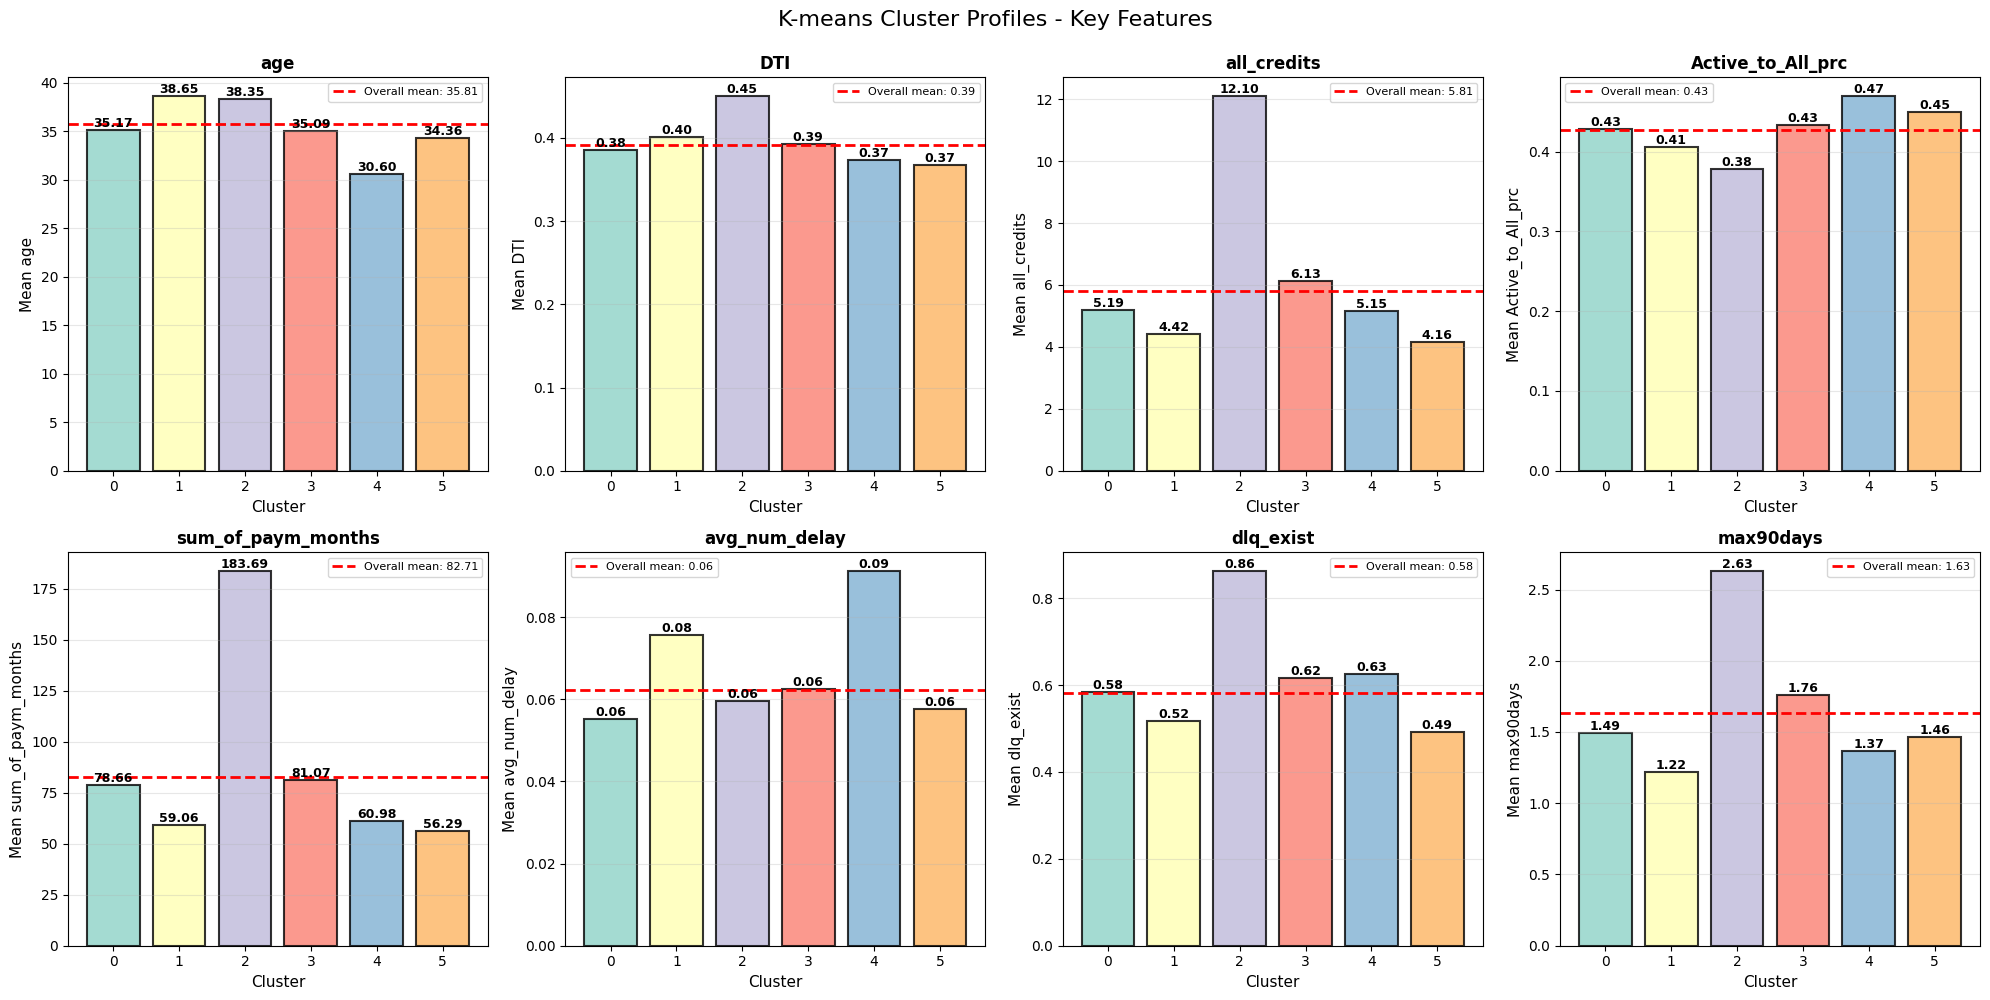

In [35]:
# - selecting top features for visualization
viz_features = ['age', 'DTI', 'all_credits', 'Active_to_All_prc',
                'sum_of_paym_months', 'avg_num_delay', 'dlq_exist', 'max90days']

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle('K-means Cluster Profiles - Key Features', fontsize=16, y=0.995)
axes = axes.flatten()

colors_clusters = plt.cm.Set3(range(optimal_k))

for idx, feature in enumerate(viz_features):
    ax = axes[idx]

    # - get mean values per cluster
    cluster_means = df_segment.groupby('cluster_kmeans')[feature].mean().sort_index()

    # - bar plot
    bars = ax.bar(cluster_means.index, cluster_means.values,
                  color=colors_clusters, alpha=0.8, edgecolor='black', linewidth=1.5)

    ax.set_xlabel('Cluster', fontsize=11)
    ax.set_ylabel(f'Mean {feature}', fontsize=11)
    ax.set_title(feature, fontsize=12, fontweight='bold')
    ax.set_xticks(range(optimal_k))
    ax.grid(axis='y', alpha=0.3)

    # - adding value labels
    for i, (cluster_id, value) in enumerate(cluster_means.items()):
        ax.text(cluster_id, value, f'{value:.2f}',
               ha='center', va='bottom', fontsize=9, fontweight='bold')

    # - adding overall mean line
    overall_mean = df_segment[feature].mean()
    ax.axhline(y=overall_mean, color='red', linestyle='--', linewidth=2,
              label=f'Overall mean: {overall_mean:.2f}')
    ax.legend(fontsize=8)

plt.tight_layout()
plt.show()

**Cluster interpretation**

Based on the analysis we assign names to each cluster for better business understanding:

- Cluster 0 "Educated Professionals" - balanced profile with higher education
- Cluster 1 "Mature Workers" - older, vocational education, salary income
- Cluster 2 "Super Active High Risk" - very high credit activity with 86% delinquency
- Cluster 3 "Second Degree Holders" - small segment with specific education
- Cluster 4 "Young Starters" - youngest group with incomplete education
- Cluster 5 "Core Stable Segment" - largest group, balanced metrics, higher education

In [36]:
# - defining cluster names
cluster_names = {
    0: "Educated Professionals",
    1: "Mature Workers",
    2: "Super Active High Risk",
    3: "Second Degree Holders",
    4: "Young Starters",
    5: "Core Stable Segment"
}

# - analyzing each cluster
for cluster_id in sorted(df_segment['cluster_kmeans'].unique()):
    cluster_data = df_segment[df_segment['cluster_kmeans'] == cluster_id]
    size = len(cluster_data)
    pct = (size / len(df_segment)) * 100

    cluster_name = cluster_names.get(cluster_id, f"Cluster {cluster_id}")

    print(f"CLUSTER {cluster_id}: {cluster_name.upper()}")
    print(f"{size} clients ({pct:.1f}%)")

    # - key stats
    print(f"\n Key characteristics:")
    print(f"   • Average age:              {cluster_data['age'].mean():.1f} years")
    print(f"   • Average DTI:              {cluster_data['DTI'].mean():.2f}")
    print(f"   • Average # of credits:     {cluster_data['all_credits'].mean():.1f}")
    print(f"   • Active account ratio:     {cluster_data['Active_to_All_prc'].mean():.2f}")
    print(f"   • Payment history (months): {cluster_data['sum_of_paym_months'].mean():.0f}")
    print(f"   • Average delay rate:       {cluster_data['avg_num_delay'].mean():.3f}")
    print(f"   • Delinquency rate:         {(cluster_data['dlq_exist'].mean()*100):.1f}%")
    print(f"   • Max 90-day delays:        {cluster_data['max90days'].mean():.1f}")

    # - demographics
    print(f"\n Demographics:")
    gender_mode = cluster_data['SEX'].mode()[0] if len(cluster_data['SEX'].mode()) > 0 else 'N/A'
    gender_pct = (cluster_data['SEX'] == gender_mode).sum() / len(cluster_data) * 100
    print(f"   • Gender:     {gender_mode} ({gender_pct:.1f}%)")

    edu_mode = cluster_data['EDUCATION'].mode()[0] if len(cluster_data['EDUCATION'].mode()) > 0 else 'N/A'
    edu_pct = (cluster_data['EDUCATION'] == edu_mode).sum() / len(cluster_data) * 100
    print(f"   • Education:  {edu_mode} ({edu_pct:.1f}%)")

    income_mode = cluster_data['INCOME_BASE_TYPE'].mode()[0] if len(cluster_data['INCOME_BASE_TYPE'].mode()) > 0 else 'N/A'
    income_pct = (cluster_data['INCOME_BASE_TYPE'] == income_mode).sum() / len(cluster_data) * 100
    print(f"   • Income type: {income_mode} ({income_pct:.1f}%)")

    # - business interpretation
    print(f"\n Business interpretation:")
    if cluster_id == 0:
        print("   Educated segment with balanced risk profile")
        print("   Moderate credit activity + payment history")
        print("   58% delinquency rate -> monitor behavior of payment")
    elif cluster_id == 1:
        print("   Mature clients with stable salary")
        print("   Lower delinquency (52%) - compared to avg")
        print("   Good targets for long term products")
    elif cluster_id == 2:
        print("   HIGHEST RISK CLUSTER - requires attention")
        print("   12.1 credits per client (vs 5.8 avg)")
        print("   86% delinquency rate - active portfolio management needed")
        print("   Consider credit limit for new applications")
    elif cluster_id == 3:
        print("   Small specialized segment with second degree education")
        print("   62% delinquency - needs monitoring")
    elif cluster_id == 4:
        print("   Youngest segment (30.6 years avg)")
        print("   Highest active account ratio (0.47)")
        print("   Higher delay rate (0.091) - typical for young clients")
        print("   Potential of growth - offer financial literacy programs")
    elif cluster_id == 5:
        print("   LARGEST + most STABLE segment (44.8%)")
        print("   Lowest delinquency rate (49.3%)")
        print("   Backbone of portfolio")
        print("   Focus on retention and cross selling")

CLUSTER 0: EDUCATED PROFESSIONALS
474 clients (13.2%)

 Key characteristics:
   • Average age:              35.2 years
   • Average DTI:              0.38
   • Average # of credits:     5.2
   • Active account ratio:     0.43
   • Payment history (months): 79
   • Average delay rate:       0.055
   • Delinquency rate:         58.4%
   • Max 90-day delays:        1.5

 Demographics:
   • Gender:     женский (50.0%)
   • Education:  Высшее/Второе высшее/Ученая степень (100.0%)
   • Income type: Форма банка (без печати работодателя) (36.9%)

 Business interpretation:
   Educated segment with balanced risk profile
   Moderate credit activity + payment history
   58% delinquency rate -> monitor behavior of payment
CLUSTER 1: MATURE WORKERS
637 clients (17.8%)

 Key characteristics:
   • Average age:              38.6 years
   • Average DTI:              0.40
   • Average # of credits:     4.4
   • Active account ratio:     0.41
   • Payment history (months): 59
   • Average delay rate:     

**RFM segmentation**

R (Recency) - Period_at_work (longer = more loyal, inverse of recency)

F (Frequency) - all_credits + numAccountActiveAll (activity level)

M (Monetary) - sum_of_paym_months (credit history depth)

In [37]:
# - creating RFM features
df_rfm = df_segment.copy()

# R
df_rfm['R_score'] = pd.qcut(df_rfm['Period_at_work'], q=5, labels=[1, 2, 3, 4, 5], duplicates='drop')

# F
df_rfm['credit_activity'] = df_rfm['all_credits'] + df_rfm['numAccountActiveAll']
df_rfm['F_score'] = pd.qcut(df_rfm['credit_activity'], q=5, labels=[1, 2, 3, 4, 5], duplicates='drop')

# M
df_rfm['M_score'] = pd.qcut(df_rfm['sum_of_paym_months'], q=5, labels=[1, 2, 3, 4, 5], duplicates='drop')

# - convert to int
df_rfm['R_score'] = df_rfm['R_score'].astype(int)
df_rfm['F_score'] = df_rfm['F_score'].astype(int)
df_rfm['M_score'] = df_rfm['M_score'].astype(int)

# - calculate total RFM score
df_rfm['RFM_score'] = df_rfm['R_score'] + df_rfm['F_score'] + df_rfm['M_score']

print(f"\n RFM score distribution:")
print(df_rfm['RFM_score'].describe())


 RFM score distribution:
count    3580.000000
mean        8.787430
std         3.299997
min         3.000000
25%         6.000000
50%         9.000000
75%        11.000000
max        15.000000
Name: RFM_score, dtype: float64


In [38]:
# - creation of segments based on RFM score and delinquency
def assign_rfm_segment(row):
    rfm = row['RFM_score']
    dlq = row['dlq_exist']
    avg_delay = row['avg_num_delay']

    # VIP - high RFM, no delinquency
    if rfm >= 12 and dlq == 0 and avg_delay < 0.05:
        return 'VIP Clients'

    # Core - good RFM, low risk
    elif rfm >= 10 and dlq == 0:
        return 'Core Clients'

    # Active - Medium RFM, some history of delays
    elif rfm >= 9 and rfm < 12:
        return 'Active Clients'

    # At Risk - low RFM / high delinquency
    elif rfm < 7 or (dlq == 1 and avg_delay > 0.1):
        return 'At Risk'

    # Need Attention - medium RFM with delinquency
    elif dlq == 1:
        return 'Need Attention'

    # New/Developing - Low/medium RFM, no major issues
    else:
        return 'Developing Clients'

df_rfm['segment_rfm'] = df_rfm.apply(assign_rfm_segment, axis=1)

print("\nRFM Segment distribution:")
rfm_segments = df_rfm['segment_rfm'].value_counts()
print("\nSegment             | Count | Percentage")
for segment, count in rfm_segments.items():
    percentage = (count / len(df_rfm)) * 100
    print(f"{segment:20s} | {count:5d} | {percentage:6.2f}%")


RFM Segment distribution:

Segment             | Count | Percentage
At Risk              |  1259 |  35.17%
Active Clients       |   843 |  23.55%
Need Attention       |   722 |  20.17%
Developing Clients   |   360 |  10.06%
Core Clients         |   213 |   5.95%
VIP Clients          |   183 |   5.11%


In [39]:
# - adding to main dataframe
df_segment['segment_rfm'] = df_rfm['segment_rfm']
df_segment['RFM_score'] = df_rfm['RFM_score']
df_segment['R_score'] = df_rfm['R_score']
df_segment['F_score'] = df_rfm['F_score']
df_segment['M_score'] = df_rfm['M_score']

Visualisation of RFM segments


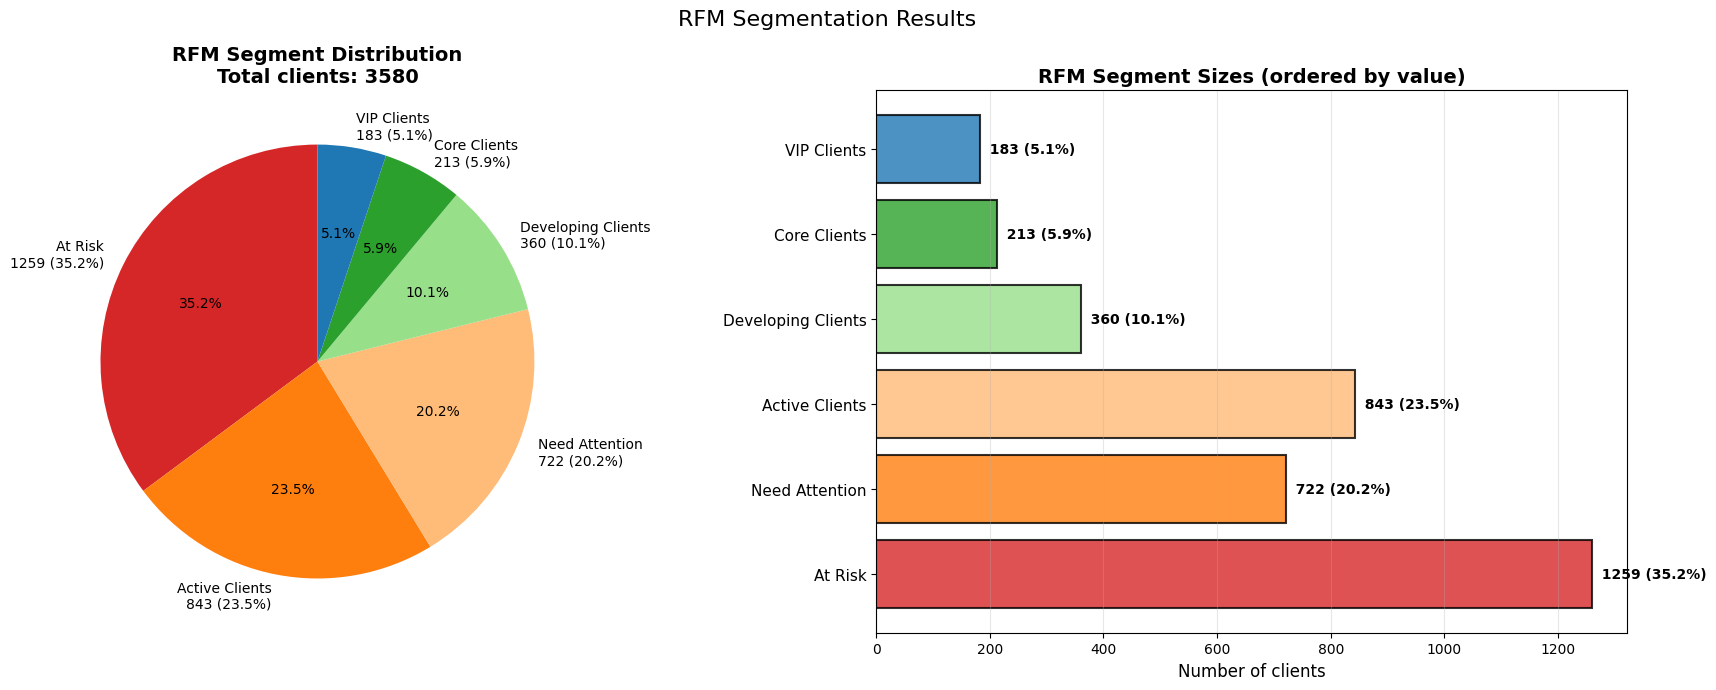

In [40]:
fig, axes = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('RFM Segmentation Results', fontsize=16, y=0.98)

# - pie chart
rfm_segments_sorted = df_segment['segment_rfm'].value_counts()
colors_rfm = ['#d62728', '#ff7f0e', '#ffbb78', '#98df8a', '#2ca02c', '#1f77b4']

axes[0].pie(rfm_segments_sorted.values,
           labels=[f'{seg}\n{count} ({count/len(df_segment)*100:.1f}%)'
                   for seg, count in rfm_segments_sorted.items()],
           autopct='%1.1f%%', colors=colors_rfm, startangle=90, textprops={'fontsize': 10})
axes[0].set_title(f'RFM Segment Distribution\nTotal clients: {len(df_segment)}',
                 fontsize=14, fontweight='bold')

# - bar chart
segment_order = ['VIP Clients', 'Core Clients', 'Developing Clients',
                'Active Clients', 'Need Attention', 'At Risk']
segment_order = [s for s in segment_order if s in rfm_segments_sorted.index]

segment_data = [rfm_segments_sorted.get(seg, 0) for seg in segment_order]
colors_ordered = ['#1f77b4', '#2ca02c', '#98df8a', '#ffbb78', '#ff7f0e', '#d62728']

bars = axes[1].barh(range(len(segment_order)), segment_data,
                    color=colors_ordered[:len(segment_order)], alpha=0.8, edgecolor='black', linewidth=1.5)
axes[1].set_yticks(range(len(segment_order)))
axes[1].set_yticklabels(segment_order, fontsize=11)
axes[1].set_xlabel('Number of clients', fontsize=12)
axes[1].set_title('RFM Segment Sizes (ordered by value)', fontsize=14, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)
axes[1].invert_yaxis()

# - adding value labels
for i, (segment, value) in enumerate(zip(segment_order, segment_data)):
    percentage = (value / len(df_segment)) * 100
    axes[1].text(value, i, f'  {value} ({percentage:.1f}%)',
                va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

Profiling

In [41]:
rfm_profiling_features = [
    'age', 'DTI', 'all_credits', 'numAccountActiveAll', 'numAccountClosed',
    'Active_to_All_prc', 'sum_of_paym_months', 'avg_num_delay', 'dlq_exist',
    'max90days', 'Period_at_work', 'RFM_score', 'R_score', 'F_score', 'M_score'
]

rfm_profiles = df_segment.groupby('segment_rfm')[rfm_profiling_features].mean()
rfm_profiles_display = rfm_profiles.round(2)

print("\n RFM Segment Profiles (Mean values):\n")
print(rfm_profiles_display.to_string())


 RFM Segment Profiles (Mean values):

                      age   DTI  all_credits  numAccountActiveAll  numAccountClosed  Active_to_All_prc  sum_of_paym_months  avg_num_delay  dlq_exist  max90days  Period_at_work  RFM_score  R_score  F_score  M_score
segment_rfm                                                                                                                                                                                                          
Active Clients      35.47  0.40         6.82                 2.55              4.26               0.40               97.45           0.08       0.88       1.69           52.43       9.98     2.91     3.45     3.62
At Risk             33.49  0.36         3.46                 1.42              2.03               0.47               41.17           0.10       0.49       1.48           32.18       5.86     2.21     1.74     1.91
Core Clients        37.29  0.42         6.40                 2.50              3.90               0.40   

In [42]:
# - detailed segment descriptions
segment_order = ['VIP Clients', 'Core Clients', 'Developing Clients',
                'Active Clients', 'Need Attention', 'At Risk']

for segment_name in segment_order:
    if segment_name not in df_segment['segment_rfm'].values:
        continue

    segment_data = df_segment[df_segment['segment_rfm'] == segment_name]
    size = len(segment_data)
    pct = (size / len(df_segment)) * 100

    print(f"{segment_name.upper()} - {size} clients ({pct:.1f}%)")

    # - RFM scores
    print(f"\n RFM Scores:")
    print(f"   • R (Work tenure):     {segment_data['R_score'].mean():.2f} / 5")
    print(f"   • F (Credit activity): {segment_data['F_score'].mean():.2f} / 5")
    print(f"   • M (Payment history): {segment_data['M_score'].mean():.2f} / 5")
    print(f"   • Total RFM score:     {segment_data['RFM_score'].mean():.2f} / 15")

    # - key characteristics
    print(f"\n Key characteristics:")
    print(f"   • Average age:              {segment_data['age'].mean():.1f} years")
    print(f"   • Average DTI:              {segment_data['DTI'].mean():.2f}")
    print(f"   • Average # of credits:     {segment_data['all_credits'].mean():.1f}")
    print(f"   • Active account ratio:     {segment_data['Active_to_All_prc'].mean():.2f}")
    print(f"   • Payment history (months): {segment_data['sum_of_paym_months'].mean():.0f}")
    print(f"   • Work tenure (months):     {segment_data['Period_at_work'].mean():.0f}")
    print(f"   • Average delay rate:       {segment_data['avg_num_delay'].mean():.3f}")
    print(f"   • Delinquency rate:         {(segment_data['dlq_exist'].mean()*100):.1f}%")
    print(f"   • Max 90-day delays:        {segment_data['max90days'].mean():.1f}")

    # - demographics
    print(f"\n Demographics:")
    gender_counts = segment_data['SEX'].value_counts()
    gender_mode = gender_counts.index[0]
    gender_pct = (gender_counts.iloc[0] / len(segment_data)) * 100
    print(f"   • Gender:      {gender_mode} ({gender_pct:.1f}%)")

    edu_mode = segment_data['EDUCATION'].mode()[0] if len(segment_data['EDUCATION'].mode()) > 0 else 'N/A'
    edu_pct = (segment_data['EDUCATION'] == edu_mode).sum() / len(segment_data) * 100
    print(f"   • Education:   {edu_mode} ({edu_pct:.1f}%)")

    income_mode = segment_data['INCOME_BASE_TYPE'].mode()[0] if len(segment_data['INCOME_BASE_TYPE'].mode()) > 0 else 'N/A'
    income_pct = (segment_data['INCOME_BASE_TYPE'] == income_mode).sum() / len(segment_data) * 100
    print(f"   • Income type: {income_mode} ({income_pct:.1f}%)")

VIP CLIENTS - 183 clients (5.1%)

 RFM Scores:
   • R (Work tenure):     4.28 / 5
   • F (Credit activity): 4.27 / 5
   • M (Payment history): 4.40 / 5
   • Total RFM score:     12.95 / 15

 Key characteristics:
   • Average age:              39.2 years
   • Average DTI:              0.44
   • Average # of credits:     9.4
   • Active account ratio:     0.37
   • Payment history (months): 140
   • Work tenure (months):     106
   • Average delay rate:       0.000
   • Delinquency rate:         0.0%
   • Max 90-day delays:        1.8

 Demographics:
   • Gender:      мужской (50.3%)
   • Education:   высшее (53.0%)
   • Income type: Форма банка (без печати работодателя) (35.5%)
CORE CLIENTS - 213 clients (5.9%)

 RFM Scores:
   • R (Work tenure):     3.59 / 5
   • F (Credit activity): 3.34 / 5
   • M (Payment history): 3.51 / 5
   • Total RFM score:     10.44 / 15

 Key characteristics:
   • Average age:              37.3 years
   • Average DTI:              0.42
   • Average # of credi

Visualisation of RFM profiles

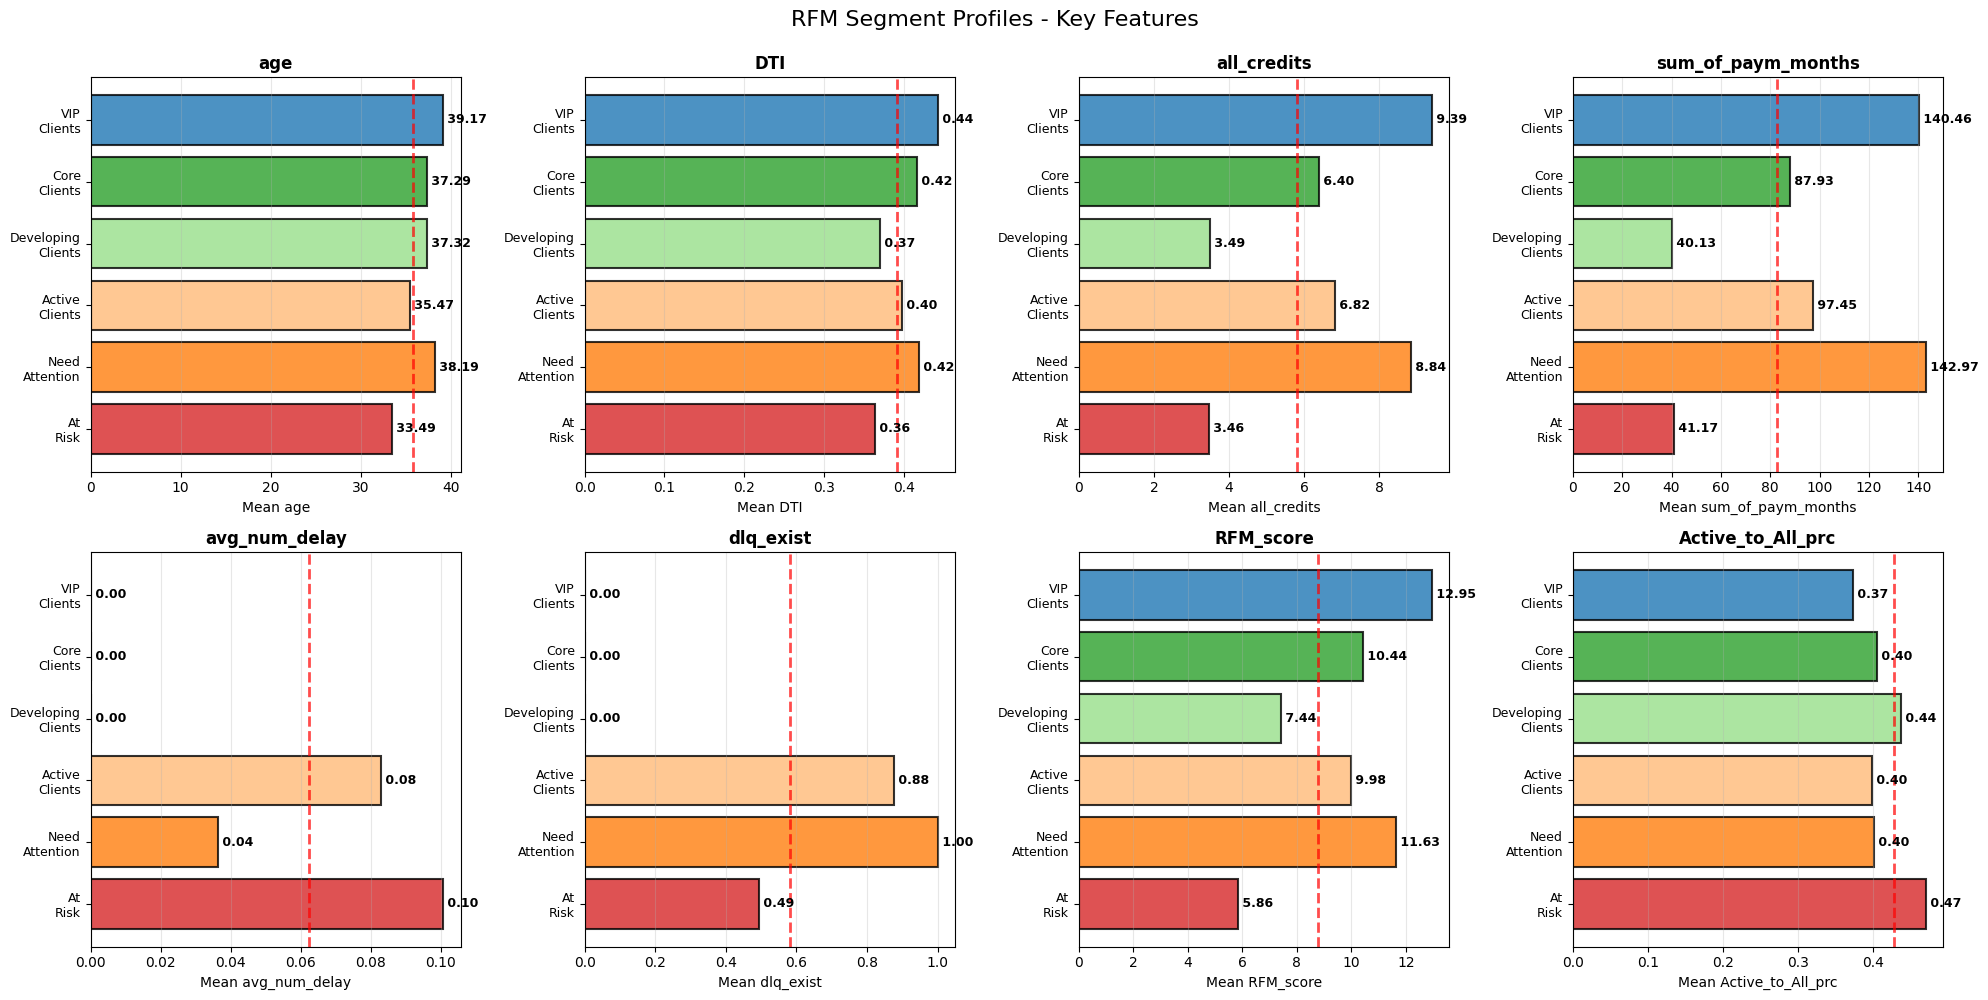

In [43]:
# - key features for visualization
viz_features_rfm = ['age', 'DTI', 'all_credits', 'sum_of_paym_months',
                   'avg_num_delay', 'dlq_exist', 'RFM_score', 'Active_to_All_prc']

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle('RFM Segment Profiles - Key Features', fontsize=16, y=0.995)
axes = axes.flatten()

segment_order_viz = ['VIP Clients', 'Core Clients', 'Developing Clients',
                     'Active Clients', 'Need Attention', 'At Risk']
colors_segments = ['#1f77b4', '#2ca02c', '#98df8a', '#ffbb78', '#ff7f0e', '#d62728']

for idx, feature in enumerate(viz_features_rfm):
    ax = axes[idx]

    # - get mean values per segment
    segment_means = df_segment.groupby('segment_rfm')[feature].mean()
    segment_means = segment_means.reindex(segment_order_viz)

    # - bar plot
    bars = ax.barh(range(len(segment_means)), segment_means.values,
                   color=colors_segments, alpha=0.8, edgecolor='black', linewidth=1.5)

    ax.set_yticks(range(len(segment_means)))
    ax.set_yticklabels([s.replace(' ', '\n') for s in segment_means.index], fontsize=9)
    ax.set_xlabel(f'Mean {feature}', fontsize=10)
    ax.set_title(feature, fontsize=12, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)
    ax.invert_yaxis()

    # - adding value labels
    for i, value in enumerate(segment_means.values):
        if not np.isnan(value):
            ax.text(value, i, f' {value:.2f}', va='center', fontsize=9, fontweight='bold')

    # - adding overall mean line
    overall_mean = df_segment[feature].mean()
    ax.axvline(x=overall_mean, color='red', linestyle='--', linewidth=2, alpha=0.7)

plt.tight_layout()
plt.show()

**Segmentation methods comparison**

In [44]:
# cross-tabulation
print("\n Cross-tabulation: K-means clusters vs RFM segments\n")
crosstab = pd.crosstab(df_segment['cluster_kmeans'], df_segment['segment_rfm'],
                       margins=True, margins_name='Total')
print(crosstab.to_string())

# normalized version (percentages within Kmeans clusters)
print("\n Percentage distribution (row-wise %):\n")
crosstab_pct = pd.crosstab(df_segment['cluster_kmeans'], df_segment['segment_rfm'],
                          normalize='index') * 100
crosstab_pct_display = crosstab_pct.round(1)
print(crosstab_pct_display.to_string())


 Cross-tabulation: K-means clusters vs RFM segments

segment_rfm     Active Clients  At Risk  Core Clients  Developing Clients  Need Attention  VIP Clients  Total
cluster_kmeans                                                                                               
0                          136      157            37                  40              80           24    474
1                          136      250            40                  90              94           27    637
2                          128       79            21                   0             326           64    618
3                           34       35             6                  10              25            5    115
4                           31       65             5                  11              13            6    131
5                          378      673           104                 209             184           57   1605
Total                      843     1259           213             

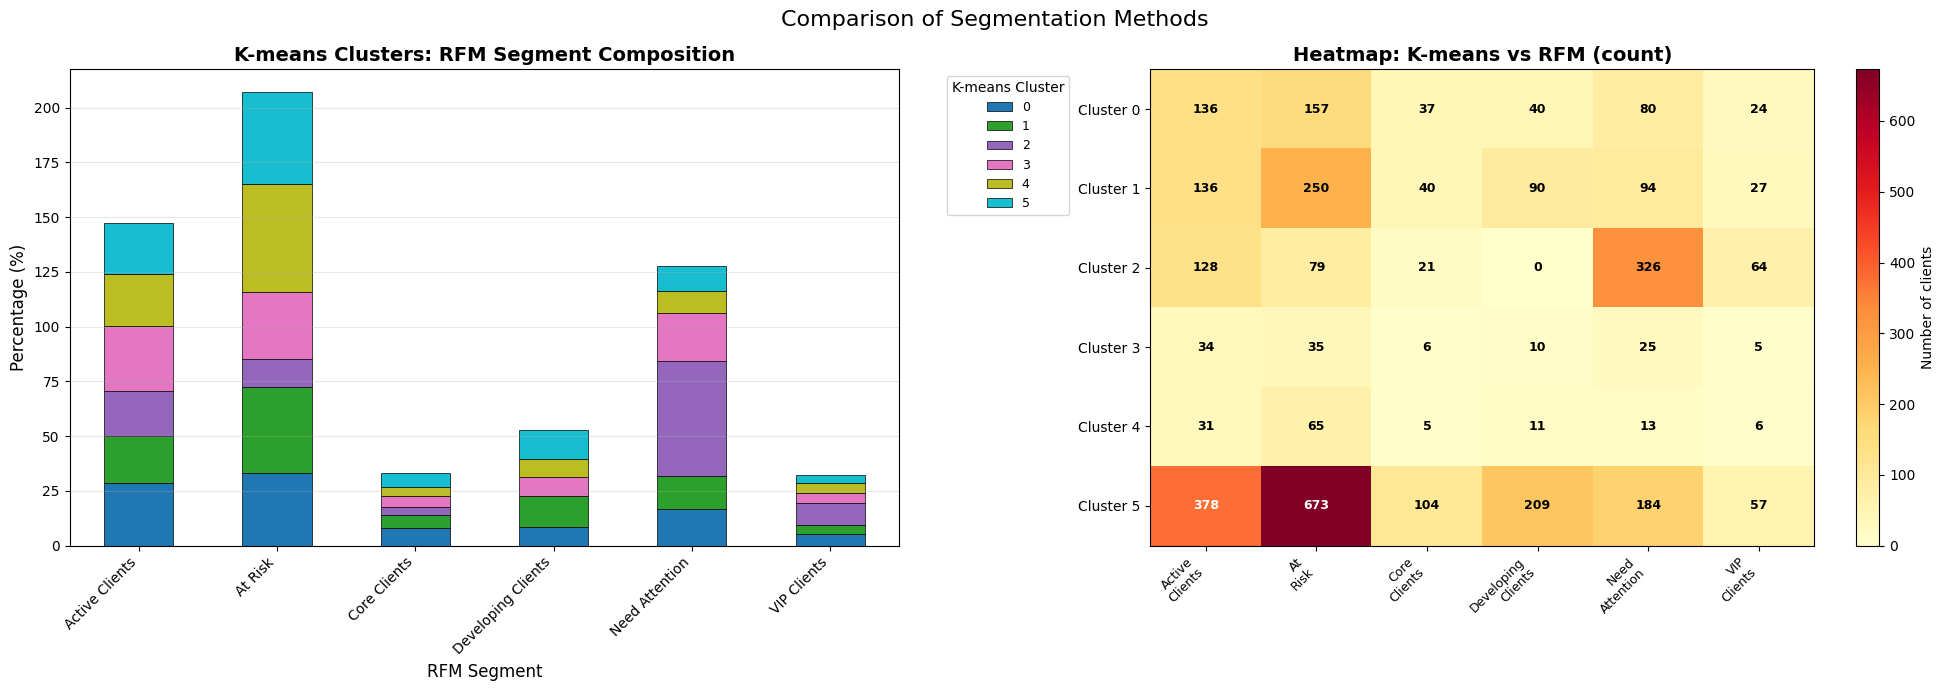

In [45]:
# visualization
fig, axes = plt.subplots(1, 2, figsize=(20, 7))
fig.suptitle('Comparison of Segmentation Methods', fontsize=16, y=0.98)

# stacked bar chart - K-means composition by RFM
crosstab_pct_T = crosstab_pct.T
crosstab_pct_T.plot(kind='bar', stacked=True, ax=axes[0],
                    colormap='tab10', edgecolor='black', linewidth=0.5)
axes[0].set_title('K-means Clusters: RFM Segment Composition', fontsize=14, fontweight='bold')
axes[0].set_xlabel('RFM Segment', fontsize=12)
axes[0].set_ylabel('Percentage (%)', fontsize=12)
axes[0].legend(title='K-means Cluster', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
axes[0].grid(axis='y', alpha=0.3)

# heatmap of cross-tabulation (counts)
crosstab_counts = pd.crosstab(df_segment['cluster_kmeans'], df_segment['segment_rfm'])
im = axes[1].imshow(crosstab_counts.values, cmap='YlOrRd', aspect='auto')

# set ticks and labels
axes[1].set_xticks(range(len(crosstab_counts.columns)))
axes[1].set_yticks(range(len(crosstab_counts.index)))
axes[1].set_xticklabels([col.replace(' ', '\n') for col in crosstab_counts.columns],
                       fontsize=9, rotation=45, ha='right')
axes[1].set_yticklabels([f'Cluster {i}' for i in crosstab_counts.index], fontsize=10)
axes[1].set_title('Heatmap: K-means vs RFM (count)', fontsize=14, fontweight='bold')

# adding text annotations
for i in range(len(crosstab_counts.index)):
    for j in range(len(crosstab_counts.columns)):
        value = crosstab_counts.values[i, j]
        text = axes[1].text(j, i, f'{value}', ha="center", va="center",
                          color="white" if value > crosstab_counts.values.max()/2 else "black",
                          fontsize=9, fontweight='bold')

# colorbar
plt.colorbar(im, ax=axes[1], label='Number of clients')

plt.tight_layout()
plt.show()

# Key insights of comparison of segmentation

The cross-tabulation shows us interesting patterns:
- Kmeans Cluster 2 (Super Active High Risk) intersects heavily with RFM "Need Attention" (52.8%)
- K-means Cluster 5 (Core Stable) is distributed across multiple RFM segments - it shows internal diversity
- Both methods complement each other - Kmeans captures patterns of behaviour, RFM focuses on business value

In [46]:
print("FINAL CONCLUSIONS & RECOMMENDATIONS")

print(f"""
 Dataset: {len(df_segment)} bank clients (from {len(df)} total records)
 Features: {len(features_for_clustering)} original to {X_scaled.shape[1]} after encoding
 Methods: K-means (unsupervised) + RFM (business rules)
 Clusters: 6 clusters in both methods (optimal balance)
""")

FINAL CONCLUSIONS & RECOMMENDATIONS

 Dataset: 3580 bank clients (from 10243 total records)
 Features: 16 original to 25 after encoding
 Methods: K-means (unsupervised) + RFM (business rules)
 Clusters: 6 clusters in both methods (optimal balance)



In [47]:
print(f"""

K-MEANS CLUSTERING (K=6):

   0. Educated Professionals (13.2%)      - Balanced profile + moderate risk
   1. Mature Workers (17.8%)              - Stable income from salary
   2. Super Active High Risk (17.3%)      - 12+ credits + 86% delinquency!
   3. Second Degree Holders (3.2%)        - Niche segment + consistent
   4. Young Starters (3.7%)               - Youngest + growth potential
   5. Core Stable Segment (44.8%)         - Largest + most reliable

 RFM SEGMENTATION (6 segments):

   VIP Clients (5.1%)           - Highest value + 0 delinquency
   Core Clients (5.9%)          - Steady + reliable
   Developing (10.1%)           - Growing potential
   Active Clients (23.5%)       - High activity + mixed risks
   Need Attention (20.2%)       - Medium risk -> requires monitoring (preventive actions)
   At Risk (35.2%)              - Low RFM + bad payment behaviour -> needs intervention

""")



K-MEANS CLUSTERING (K=6):
   
   0. Educated Professionals (13.2%)      - Balanced profile + moderate risk
   1. Mature Workers (17.8%)              - Stable income from salary
   2. Super Active High Risk (17.3%)      - 12+ credits + 86% delinquency!
   3. Second Degree Holders (3.2%)        - Niche segment + consistent
   4. Young Starters (3.7%)               - Youngest + growth potential
   5. Core Stable Segment (44.8%)         - Largest + most reliable

 RFM SEGMENTATION (6 segments):
   
   VIP Clients (5.1%)           - Highest value + 0 delinquency
   Core Clients (5.9%)          - Steady + reliable
   Developing (10.1%)           - Growing potential
   Active Clients (23.5%)       - High activity + mixed risks
   Need Attention (20.2%)       - Medium risk -> requires monitoring (preventive actions)
   At Risk (35.2%)              - Low RFM + bad payment behaviour -> needs intervention




In [48]:
print("BUSINESS RECOMMENDATIONS BY SEGMENT:")

recommendations = {
    'At Risk (35.2%)': [
        'Most problematic group',
        'Limit further credit exposure',
        'Implement faster collections system and early warning alerts',
        'Offer debt restructuring - to avoid default',
        'Investigate root cause - why 35% are at risk?'
    ],
    'Need Attention (20.2%)': [
        'Contact them proactively - before they become At Risk',
        'Send reminds (via SMS/email)',
        'Personal support for high value cases',
        'Prepare collection plan, but firstly focus on prevention'
    ],
    'Active Clients (23.5%)': [
        'Monitor behaviour of payment close',
        'Offer financial education programms',
        'Provide restructuring - before they miss many payments',
        'Risk based pricing for new loans'
    ],
    'Developing (10.1%)': [
        'Gradually increase credit limits - only when stable persomance',
        'Share educational content on credit management',
        'Incentives/rewards for consistent payments',
        'Create a plan to move them to "Core" or "VIP"'
    ],
    'Core Clients (5.9%)': [
        'Cross selling opportunities (insurance/investments/etc)',
        'Loyalty programs and referral bonuses',
        'Identify whi can gain VIP status',
        'Regular engagement - to prevent churn'
    ],
    'VIP Clients (5.1%)': [
        'Personal service with account managers',
        'Exclusive offers + early access to the new products',
        'Higher limits and better rates',
        'VIP events and recognition programs',
        'Maximum protection to this group - they generate high profit'
    ]
}

for segment, actions in recommendations.items():
    print(f"\n{segment}:")
    for action in actions:
        print(f"   {action}")

BUSINESS RECOMMENDATIONS BY SEGMENT:

At Risk (35.2%):
   Most problematic group
   Limit further credit exposure
   Implement faster collections system and early warning alerts
   Offer debt restructuring - to avoid default
   Investigate root cause - why 35% are at risk?

Need Attention (20.2%):
   Contact them proactively - before they become At Risk
   Send reminds (via SMS/email)
   Personal support for high value cases
   Prepare collection plan, but firstly focus on prevention

Active Clients (23.5%):
   Monitor behaviour of payment close
   Offer financial education programms
   Provide restructuring - before they miss many payments
   Risk based pricing for new loans

Developing (10.1%):
   Gradually increase credit limits - only when stable persomance
   Share educational content on credit management
   Incentives/rewards for consistent payments
   Create a plan to move them to "Core" or "VIP"

Core Clients (5.9%):
   Cross selling opportunities (insurance/investments/etc)
  

In [49]:
print("CRITICAL RISKS IDENTIFIED:")

print(f"""
1. 55% clients - high-risk categories (At Risk + Need Attention)
   - Overall portfolio quality is poor and needs immediate improvements

2. K-means Cluster 2 (17.3%) has 86% delinquency
   - Segment with many credits and issues with payments
   - 12.1 credits (per client) vs 5.8 avg
   - Immediate risk plan required

3. Overall delinquency rate - 58.2%
   - Industry standard is usually 5-15%
   - Suggests either:
      a) Credit approval criteria are too soft
      b) Not effective payment monitoring
      c) Customer base has financial issues

4. Only 11% are VIP/Core clients
   - Focus on converting "Developing" and "Active" to "Core"/"VIP"
   - Retention on existing VIP/Core - crucial
""")

CRITICAL RISKS IDENTIFIED:

1. 55% clients - high-risk categories (At Risk + Need Attention)
   - Overall portfolio quality is poor and needs immediate improvements
   
2. K-means Cluster 2 (17.3%) has 86% delinquency
   - Segment with many credits and issues with payments
   - 12.1 credits (per client) vs 5.8 avg
   - Immediate risk plan required
   
3. Overall delinquency rate - 58.2%
   - Industry standard is usually 5-15%
   - Suggests either:
      a) Credit approval criteria are too soft
      b) Not effective payment monitoring
      c) Customer base has financial issues
   
4. Only 11% are VIP/Core clients
   - Focus on converting "Developing" and "Active" to "Core"/"VIP"
   - Retention on existing VIP/Core - crucial



In [50]:
print("STRATEGIC PRIORITIES:")

print("""
Short-term (0-3 months):
   1. Introduce early warning system for "At Risk"
   2. Review credit policy for Cluster 2 (Super Active High Risk)
   3. Launch payment reminder campaigns

Medium-term (3-6 months):
   1. Develop and launch financial literacy programs for "Young Starters"
   2. Create loyalty program for VIP/Core clients
   3. Implement pricing besed on risks

Long-term (6-12 months):
   1. Adjust the structure of portfolio to reduce the share of high risk clients
   2. Develop predictive models to prevent future delinquency
   3. Grow VIP segment from 5% to 10% via client development and retention
""")

STRATEGIC PRIORITIES:

Short-term (0-3 months):
   1. Introduce early warning system for "At Risk"
   2. Review credit policy for Cluster 2 (Super Active High Risk)
   3. Launch payment reminder campaigns

Medium-term (3-6 months):
   1. Develop and launch financial literacy programs for "Young Starters"
   2. Create loyalty program for VIP/Core clients
   3. Implement pricing besed on risks

Long-term (6-12 months):
   1. Adjust the structure of portfolio to reduce the share of high risk clients
   2. Develop predictive models to prevent future delinquency
   3. Grow VIP segment from 5% to 10% via client development and retention

